## Preparation

In [1]:
import datetime, os
import pandas as pd
pd.set_option('display.max.colwidth', 100)
import numpy as np
import gensim
import re
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine, cdist
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer

/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
2023-06-25 01:38:04.109752: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from gensim.models import word2vec, Word2Vec

In [2]:
class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''

    def __init__(self, model_dir, path_prefix):
        self.path_prefix = path_prefix
        self.model_dir = model_dir
        self.epoch = 0

    def on_epoch_end(self, model):
        self.epoch += 1
        
    def on_train_end(self, model):
        model.save('{}/{}_epoch{}.model'.format(self.model_dir, self.path_prefix, self.epoch))

class EpochLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model3):
        loss = model3.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        if self.epoch % 50 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [3]:
# Smooth Inverse Frequency 
def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in xrange(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [3]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
contracts = pd.read_excel("../data/Contracts.xlsx")
# contracts = pd.read_excel("../data/Contracts_v2.xlsx")
outcomes = pd.DataFrame()
titles = pd.DataFrame()
for year in years:
    temp_outcome = pd.read_excel("../data/EXPORT"+str(year)+".xlsx").set_index('관리번호')
    temp_title = pd.read_excel("../data/"+str(year)+".xlsx").set_index('관리번호')
    outcomes = pd.concat([outcomes, temp_outcome], axis=0)
    titles = pd.concat([titles,temp_title], axis=0)

In [4]:
outcomes

,예외,학년도,성과물구분,성과물구분명,기준일,제목,상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,
20646,NaN,2015,1,논문,2015-05-30,YouTube acceptance by university educators and students: a cross-cultural perspective,특수대학원,교육대학원,111217,이예경,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21054,NaN,2015,1,논문,2015-10-01,Emotional information processing based on feature vector enhancement and selection for human-com...,공학부,컴퓨터공학전공,101623,김지환,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21110,NaN,2015,1,논문,2015-04-01,Controller Design for Mechanical Impedance Reduction,공학부,기계공학전공,111847,공경철,201431009.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21597,NaN,2015,1,논문,2015-05-01,Perceived stigma of alcohol dependency: comparative influence on patients and family members,전문대학원,경영전문대학원,101434,신호창,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,3
21636,NaN,2015,1,논문,2015-12-21,Multisensory fashion communication media towards impression management,전문대학원,영상대학원,113308,최용순,201310044.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000000571,NaN,2020,8,창작,2020-11-27,Sookkyung and Jini,전문대학원,영상대학원,113064,"Unger, Michael Anthony",NaN,예,예,아니오,파일제출(파일업로드),False,NaN,NaN,0
7000000581,NaN,2020,8,창작,2020-12-04,Viewporter,지식융합미디어학부,아트&테크놀로지전공,116589,주진호,NaN,예,아니오,아니오,파일제출(파일업로드),False,NaN,NaN,0
8000002992,NaN,2020,9,연구보고서,2020-11-30,포스트 코로나 시대에 초·중등학생을 위한 대안적 교육매체로써 인터넷 활용,전문대학원,신학대학원,101422,강선경,202061012.0,예,예,아니오,파일제출(파일업로드),False,NaN,NaN,0


In [5]:
outcomes = pd.concat([outcomes, titles['제목(영어)']], axis=1)
outcomes = outcomes[['예외', '학년도', '성과물구분', '성과물구분명', '기준일', '제목', '제목(영어)', '상위소속명', '소속명', '교직원번호',
       '성명', '관련연구과제', '발송여부', '성과물확인', '교원업적', '자료제출방법', '연동여부(KRI)', '검증여부',
       '전송일시(KRI)', '총저자수']]

In [6]:
outcomes['성과물구분명'].unique()

array(['논문', '저서', '학술회의발표', '수상', '특허', '기술이전', '교외연구비', '창작', '연구보고서'],
      dtype=object)

In [7]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])]
title_inv = inventions['제목(영어)'].drop_duplicates(keep='first')

In [8]:
inventions

,예외,학년도,성과물구분,성과물구분명,기준일,제목,제목(영어),상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,,
20646,NaN,2015,1,논문,2015-05-30,YouTube acceptance by university educators and students: a cross-cultural perspective,YouTube acceptance by university educators and students: a cross-cultural perspective,특수대학원,교육대학원,111217,이예경,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21054,NaN,2015,1,논문,2015-10-01,Emotional information processing based on feature vector enhancement and selection for human-com...,Emotional information processing based on feature vector enhancement and selection for human-com...,공학부,컴퓨터공학전공,101623,김지환,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21110,NaN,2015,1,논문,2015-04-01,Controller Design for Mechanical Impedance Reduction,Controller Design for Mechanical Impedance Reduction,공학부,기계공학전공,111847,공경철,201431009.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21597,NaN,2015,1,논문,2015-05-01,Perceived stigma of alcohol dependency: comparative influence on patients and family members,Perceived stigma of alcohol dependency: comparative influence on patients and family members,전문대학원,경영전문대학원,101434,신호창,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,3
21636,NaN,2015,1,논문,2015-12-21,Multisensory fashion communication media towards impression management,Multisensory fashion communication media towards impression management,전문대학원,영상대학원,113308,최용순,201310044.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6000023112,NaN,2020,7,교외연구비,2020-10-08,현대모비스 SW 인력양성 프로그램 운영,Operation of Hyundai Mobis SW Human Resource Training Program,공학부,전자공학전공,114376,강석주,202070058.0,예,예,아니오,NaN,False,NaN,NaN,0
6000023113,NaN,2020,7,교외연구비,2021-02-24,C1 가스 전환 기술 공통시험 연구,A Common Test Study on C1 Gas Conversion Technology,공학부,화공생명공학전공,117419,김형준,202132010.0,예,예,아니오,NaN,False,NaN,NaN,0
8000002992,NaN,2020,9,연구보고서,2020-11-30,포스트 코로나 시대에 초·중등학생을 위한 대안적 교육매체로써 인터넷 활용,Using the Internet as an alternative educational medium for elementary and secondary school stud...,전문대학원,신학대학원,101422,강선경,202061012.0,예,예,아니오,파일제출(파일업로드),False,NaN,NaN,0


In [15]:
inventions["성명"].unique().shape

(621,)

In [8]:
contracts

,No,년도,계약일,개월수,계약번호,계약명칭,기술사업부 담당자,출원인,업체명,업체담당자,담당자 이메일,담당자 연락처,책임발명자,학과,차수,입금일자,입금액,합계,기술구분,실시조건
0,1,2020,2020-12-21,5,T2020-0033,초고속 5G 통신용 세라믹 RF 공진 필터 개발 노하우 기술이전,NaN,NaN,주식회사 릿치마이크로웨이브,NaN,kjchel00@hanmail.net,NaN,이기진,물리학전공,1.0,2020-12-24,10000000.0,10000000.0,Know-How,노하우
1,2,2020,2020-12-21,5,T2020-0038,스테레오 노이즈 제거 장치 및 스테레오 노이즈 제거 방법 외 4건 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 엠피웨이브(mpWAV Inc.),NaN,NaN,NaN,박형민,전자공학전공,1.0,2022-12-21,7979091.0,53070000.0,특허,매매
2,3,2020,2020-12-21,5,T2020-0039,우도 최대화를 이용한 빔포밍 방법 외 2건 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 엠피웨이브(mpWAV Inc.),NaN,NaN,NaN,박형민,전자공학전공,3.0,2024-12-21,17272728.0,32450000.0,특허,매매
3,4,2020,2020-12-21,5,T2020-0039,우도 최대화를 이용한 빔포밍 방법 외 2건 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 엠피웨이브(mpWAV Inc.),NaN,NaN,NaN,박형민,전자공학전공,2.0,2023-12-21,10363636.0,32450000.0,특허,매매
4,5,2020,2020-12-21,5,T2020-0030,족저압을 이용한 보행보조장치의 제어방법 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 스마트샛(SMARTSAT Inc.),NaN,smartsatony@gmail.com,NaN,신충수,기계공학전공,1.0,2021-02-28,18181818.0,18181818.0,특허,매매
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,539,2015,2015-02-12,75,T2015-0005,워터리타더 다상 성능해석 노하우 기술이전,NaN,NaN,한국파워트레인㈜,NaN,ijkwag@kapec.com,NaN,허남건,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
539,540,2015,2015-02-01,75,T2015-0003,무전원/무선 인체계측을 위한 PSRS(Pressure Sensing Resistor Sensor) 기술,NaN,NaN,(주)스마텍,NaN,soonbae@chol.com,NaN,최범규,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
540,541,2015,2015-02-01,75,T2015-0002,인텔리전트 타이어용 압력 센서 설계 및 칩 제작 기술,NaN,NaN,(주)원웨이브,NaN,ybybjes@naver.com,NaN,최범규,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
541,542,2015,2015-01-30,76,T2015-0006,미래 지능형 헬스케어 플랫폼을 위한 고속 신호 인터페이스 회로 개발 노하우 기술이전,NaN,NaN,(주)엠텍비젼에셋,NaN,NaN,NaN,범진욱,전자공학전공,1.0,2015-03-31,12000000.0,12000000.0,Know-How,노하우


In [38]:
outcomes_tech = outcomes[outcomes['성과물구분명']=='기술이전']
title_tech = []
index_tech = []
technologies = []
for i in tqdm(range(len(outcomes_tech))):
    if outcomes_tech.iloc[i]['제목'] in list(contracts['계약명칭']):
#         print(outcomes_tech.iloc[i]['성명'], contracts.iloc[list(contracts['계약명칭']).index(outcomes_tech.iloc[i]['제목'])]['책임발명자'])
        index_contract = contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]
        if pd.DataFrame(contracts.loc[index_contract]).T['학과'].isna().item():
            continue
        title_tech.append(outcomes_tech.iloc[i]['제목(영어)'])
        index_tech.append(outcomes_tech.iloc[i].name)
        
        technologies.append(pd.concat([pd.Series(outcomes_tech.iloc[i].name).rename({0: "관리번호"}), pd.Series(outcomes_tech.iloc[i]['제목(영어)']).rename({0: "제목"}), contracts.loc[index_contract]]))
title_tech = pd.Series(title_tech, index=index_tech)#.drop_duplicates(keep='first')
# title_tech = pd.Series(title_tech, index=index_tech).drop_duplicates(keep='first')
technologies = pd.concat(technologies, axis=1).T
technologies = technologies.drop(technologies['학과'][technologies['학과'].isna()].index)

100%|██████████| 631/631 [00:02<00:00, 305.61it/s]


In [20]:
outcomes

,예외,학년도,성과물구분,성과물구분명,기준일,제목,제목(영어),상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,,
20646,NaN,2015,1,논문,2015-05-30,YouTube acceptance by university educators and students: a cross-cultural perspective,YouTube acceptance by university educators and students: a cross-cultural perspective,특수대학원,교육대학원,111217,이예경,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21054,NaN,2015,1,논문,2015-10-01,Emotional information processing based on feature vector enhancement and selection for human-com...,Emotional information processing based on feature vector enhancement and selection for human-com...,공학부,컴퓨터공학전공,101623,김지환,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21110,NaN,2015,1,논문,2015-04-01,Controller Design for Mechanical Impedance Reduction,Controller Design for Mechanical Impedance Reduction,공학부,기계공학전공,111847,공경철,201431009.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21597,NaN,2015,1,논문,2015-05-01,Perceived stigma of alcohol dependency: comparative influence on patients and family members,Perceived stigma of alcohol dependency: comparative influence on patients and family members,전문대학원,경영전문대학원,101434,신호창,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,3
21636,NaN,2015,1,논문,2015-12-21,Multisensory fashion communication media towards impression management,Multisensory fashion communication media towards impression management,전문대학원,영상대학원,113308,최용순,201310044.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000000571,NaN,2020,8,창작,2020-11-27,Sookkyung and Jini,Sookkyung and Jini,전문대학원,영상대학원,113064,"Unger, Michael Anthony",NaN,예,예,아니오,파일제출(파일업로드),False,NaN,NaN,0
7000000581,NaN,2020,8,창작,2020-12-04,Viewporter,Viewporter,지식융합미디어학부,아트&테크놀로지전공,116589,주진호,NaN,예,아니오,아니오,파일제출(파일업로드),False,NaN,NaN,0
8000002992,NaN,2020,9,연구보고서,2020-11-30,포스트 코로나 시대에 초·중등학생을 위한 대안적 교육매체로써 인터넷 활용,Using the Internet as an alternative educational medium for elementary and secondary school stud...,전문대학원,신학대학원,101422,강선경,202061012.0,예,예,아니오,파일제출(파일업로드),False,NaN,NaN,0


In [21]:
inventions.shape

(23281, 20)

In [14]:
outcomes_tech

,예외,학년도,성과물구분,성과물구분명,기준일,제목,제목(영어),상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,,
5000000732,NaN,2015,6,기술이전,2015-05-22,12bit 500k SPS CMOS SAR ADC IP 노하우(Know-How) 기술이전,12bit 500k SPS CMOS SAR ADC IP Know-how technology transfer,공학부,전자공학전공,101652,안길초,NaN,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000736,NaN,2015,6,기술이전,2015-03-30,MOSFET의 HCI and BTI stress에 따른 circuit-level 신뢰성 연구,A Study on the Circuit-Level Reliability of MOSFET under HCI and BTI Stress,NaN,서강미래기술원,110966,윤규한,201436001.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000737,NaN,2015,6,기술이전,2015-03-31,미래 지능형 헬스케어 플랫폼을 위한 고속 신호 인터페이스 회로 개발 노하우 기술이전,Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...,공학부,전자공학전공,101336,범진욱,201480018.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000739,NaN,2015,6,기술이전,2015-04-01,12b low-power SAR-type ADC IP(3종),12b low-power SAR-type ADC IP(3종),공학부,전자공학전공,101238,이승훈,201436001.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000740,NaN,2015,6,기술이전,2015-04-10,이미지센서 설계능력 증진 및 화질 개선 노하우 이전,Improving image sensor design capabilities and transferring know-how to improve image quality,공학부,전자공학전공,114190,최희철,201436001.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000002144,NaN,2020,6,기술이전,2020-12-16,3차원 자동 유방 초음파 영상 장치 시스템 설계 기술,3D Automatic Breast Ultrasonic Imaging System Design Technology,공학부,전자공학전공,101320,송태경,NaN,예,예,아니오,NaN,False,NaN,NaN,0
5000002146,NaN,2020,6,기술이전,2020-03-25,MALDI-TOF 질량분석방법을 이용한 고분자내 올리고머의 정량분석 방법,Quantitative Analysis of Oligomers in Polymers Using MALDI-TOF Mass Analysis Method,자연과학부,화학전공,101431,문봉진,NaN,예,예,아니오,NaN,False,NaN,NaN,0
5000002148,NaN,2020,6,기술이전,2020-03-25,MALDI-TOF 질량분석방법을 이용한 고분자내 올리고머의 정량분석 방법,Quantitative Analysis of Oligomers in Polymers Using MALDI-TOF Mass Analysis Method,자연과학부,화학전공,101450,오한빈,NaN,예,예,아니오,NaN,False,NaN,NaN,0


In [15]:
temp = outcomes[~outcomes["관련연구과제"].isna()][["관련연구과제", "성과물구분명", "제목"]].set_index("관련연구과제")

In [16]:
i=np.unique(outcomes[~outcomes["관련연구과제"].isna()]["관련연구과제"])[2]

In [17]:
"논문" in np.unique(temp.loc[i]["성과물구분명"]) and "특허" in np.unique(temp.loc[i]["성과물구분명"])

False

In [62]:
cnt = 0
for i in np.unique(outcomes[~outcomes["관련연구과제"].isna()]["관련연구과제"]):
    if "논문" in np.unique(temp.loc[i]["성과물구분명"]) and "특허" in np.unique(temp.loc[i]["성과물구분명"]):
        cnt += 1

In [66]:
np.unique(outcomes[~outcomes["관련연구과제"].isna()]["관련연구과제"]).shape

(5171,)

In [63]:
cnt

73

In [223]:
index_contract = contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.loc[5000001490]['제목']).notna()].index[0]

In [247]:
pd.DataFrame(contracts.loc[index_contract]).T['학과'].isna().item()

False

In [218]:
contracts.loc[index_contract]['학과']

'전자공학전공'

In [19]:
technologies.iloc[technologies['학과'][technologies['학과'].isna()].index]

,관리번호,제목,No,년도,계약일,개월수,계약번호,계약명칭,기술사업부 담당자,출원인,...,담당자 이메일,담당자 연락처,책임발명자,학과,차수,입금일자,입금액,합계,기술구분,실시조건


In [18]:
outcomes_tech

,예외,학년도,성과물구분,성과물구분명,기준일,제목,제목(영어),상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,,
5000000732,NaN,2015,6,기술이전,2015-05-22,12bit 500k SPS CMOS SAR ADC IP 노하우(Know-How) 기술이전,12bit 500k SPS CMOS SAR ADC IP Know-how technology transfer,공학부,전자공학전공,101652,안길초,NaN,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000736,NaN,2015,6,기술이전,2015-03-30,MOSFET의 HCI and BTI stress에 따른 circuit-level 신뢰성 연구,A Study on the Circuit-Level Reliability of MOSFET under HCI and BTI Stress,NaN,서강미래기술원,110966,윤규한,201436001.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000737,NaN,2015,6,기술이전,2015-03-31,미래 지능형 헬스케어 플랫폼을 위한 고속 신호 인터페이스 회로 개발 노하우 기술이전,Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...,공학부,전자공학전공,101336,범진욱,201480018.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000739,NaN,2015,6,기술이전,2015-04-01,12b low-power SAR-type ADC IP(3종),12b low-power SAR-type ADC IP(3종),공학부,전자공학전공,101238,이승훈,201436001.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
5000000740,NaN,2015,6,기술이전,2015-04-10,이미지센서 설계능력 증진 및 화질 개선 노하우 이전,Improving image sensor design capabilities and transferring know-how to improve image quality,공학부,전자공학전공,114190,최희철,201436001.0,예,예,예,파일제출(파일업로드),False,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000002144,NaN,2020,6,기술이전,2020-12-16,3차원 자동 유방 초음파 영상 장치 시스템 설계 기술,3D Automatic Breast Ultrasonic Imaging System Design Technology,공학부,전자공학전공,101320,송태경,NaN,예,예,아니오,NaN,False,NaN,NaN,0
5000002146,NaN,2020,6,기술이전,2020-03-25,MALDI-TOF 질량분석방법을 이용한 고분자내 올리고머의 정량분석 방법,Quantitative Analysis of Oligomers in Polymers Using MALDI-TOF Mass Analysis Method,자연과학부,화학전공,101431,문봉진,NaN,예,예,아니오,NaN,False,NaN,NaN,0
5000002148,NaN,2020,6,기술이전,2020-03-25,MALDI-TOF 질량분석방법을 이용한 고분자내 올리고머의 정량분석 방법,Quantitative Analysis of Oligomers in Polymers Using MALDI-TOF Mass Analysis Method,자연과학부,화학전공,101450,오한빈,NaN,예,예,아니오,NaN,False,NaN,NaN,0


In [187]:
index_contract

175

In [269]:
# technologies에 속한 inventor 중 inventions에 존재하지 않는 경우의 수 => matching이 될 수 없는 경우
technologies.loc[title_tech.index]['name'][technologies.loc[title_tech.index]['name'].apply(lambda x: True if x in inventions.loc[list_inv.index]['name'].unique() else False)]

5000000737    범진욱
5000000739    이승훈
5000000741    손기헌
5000000751    박운상
5000000771    김주섭
             ... 
5000002043    정옥현
5000002044    강석주
5000002045    박형민
5000002046    구명완
5000002048    박형민
Name: name, Length: 380, dtype: object

In [267]:
inventions.loc[list_inv.index]['name'].unique()

array(['이예경', '김지환', '공경철', '신호창', '최용순', '신형두', '황선영', '김낙수', '윤광석',
       '김주영', '김원정', '오영탁', '유양모', '김승욱', '정진호', '김현철', '송민섭', '박래홍',
       '최우영', 'Barrie Michael Jonathan Mathew', '허남건', '손기헌', '김대중',
       '김동철', '이형일', '김충현', 'Loh, Kah Seng', '주하연', '안태현', '김대산', '이갑열',
       '김종락', '심종혁', '최수정', '이정국', 'Gueron, Yves Simon Bernard', '김재영',
       '임채호', '한기백', '박운상', 'Unger, Michael Anthony', '장진호', '이준겸', '이정민',
       '이범훈', '신관우', '주봉건', '오한빈', '이욱연', '민재형', '이윤수', '홍대식', '김성룡',
       '김광수', '허윤', '정문열', '이영주', '정순영', '이보아', '황화상', '김범수', '구기갑',
       '김연신', '강선경', '나은영', '전성빈', '조범환', '이현수', '장재윤', '심재진', '이근욱',
       '조영호', '김영록', '이수영', '이진원', '이규호', '차혁진', '이광순', '김소연', '강병규',
       '낭종호', '송효섭', '박병관', '장형수', '오세용', '정소이', '박준우', '이상근', '박흥목',
       '유현재', '장덕조', '윤경병', '김치헌', '김진욱', '문준혁', '박수진', '김종철', '정재학',
       '서지원', '이정진', '김상수', '정현식', '김원태', '박정열', '김근영', '왕규호', '이한식',
       '임종섭', '남준우', '이원구', '김용진', '최우찬', 'Yoo Isaiah WonHo', '임지봉',
       '홍석철',

In [22]:
contracts.loc[index_contract]

No                                                         176
년도                                                        2018
계약일                                        2018-06-01 00:00:00
개월수                                                         35
계약번호                                                T2018-0039
계약명칭         휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
기술사업부 담당자                                                  NaN
출원인                                                        NaN
업체명                                                     (주)질경이
업체담당자                                                      NaN
담당자 이메일                                     jilgyungyi@hudc.co
담당자 연락처                                                    NaN
책임발명자                                                      정옥현
학과                                                      전자공학전공
차수                                                         6.0
입금일자                                       2020-12-01 0

In [17]:
contracts

,No,년도,계약일,개월수,계약번호,계약명칭,기술사업부 담당자,출원인,업체명,업체담당자,담당자 이메일,담당자 연락처,책임발명자,학과,차수,입금일자,입금액,합계,기술구분,실시조건
0,1,2020,2020-12-21,5,T2020-0033,초고속 5G 통신용 세라믹 RF 공진 필터 개발 노하우 기술이전,NaN,NaN,주식회사 릿치마이크로웨이브,NaN,kjchel00@hanmail.net,NaN,이기진,물리학전공,1.0,2020-12-24,10000000.0,10000000.0,Know-How,노하우
1,2,2020,2020-12-21,5,T2020-0038,스테레오 노이즈 제거 장치 및 스테레오 노이즈 제거 방법 외 4건 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 엠피웨이브(mpWAV Inc.),NaN,NaN,NaN,박형민,전자공학전공,1.0,2022-12-21,7979091.0,53070000.0,특허,매매
2,3,2020,2020-12-21,5,T2020-0039,우도 최대화를 이용한 빔포밍 방법 외 2건 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 엠피웨이브(mpWAV Inc.),NaN,NaN,NaN,박형민,전자공학전공,3.0,2024-12-21,17272728.0,32450000.0,특허,매매
3,4,2020,2020-12-21,5,T2020-0039,우도 최대화를 이용한 빔포밍 방법 외 2건 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 엠피웨이브(mpWAV Inc.),NaN,NaN,NaN,박형민,전자공학전공,2.0,2023-12-21,10363636.0,32450000.0,특허,매매
4,5,2020,2020-12-21,5,T2020-0030,족저압을 이용한 보행보조장치의 제어방법 특허 권리양도 기술이전,NaN,서강대학교 산학협력단,주식회사 스마트샛(SMARTSAT Inc.),NaN,smartsatony@gmail.com,NaN,신충수,기계공학전공,1.0,2021-02-28,18181818.0,18181818.0,특허,매매
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,539,2015,2015-02-12,75,T2015-0005,워터리타더 다상 성능해석 노하우 기술이전,NaN,NaN,한국파워트레인㈜,NaN,ijkwag@kapec.com,NaN,허남건,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
539,540,2015,2015-02-01,75,T2015-0003,무전원/무선 인체계측을 위한 PSRS(Pressure Sensing Resistor Sensor) 기술,NaN,NaN,(주)스마텍,NaN,soonbae@chol.com,NaN,최범규,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
540,541,2015,2015-02-01,75,T2015-0002,인텔리전트 타이어용 압력 센서 설계 및 칩 제작 기술,NaN,NaN,(주)원웨이브,NaN,ybybjes@naver.com,NaN,최범규,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
541,542,2015,2015-01-30,76,T2015-0006,미래 지능형 헬스케어 플랫폼을 위한 고속 신호 인터페이스 회로 개발 노하우 기술이전,NaN,NaN,(주)엠텍비젼에셋,NaN,NaN,NaN,범진욱,전자공학전공,1.0,2015-03-31,12000000.0,12000000.0,Know-How,노하우


In [191]:
outcomes_tech.iloc[i]

예외                                                                                                           NaN
학년도                                                                                                         2015
성과물구분                                                                                                          6
성과물구분명                                                                                                      기술이전
기준일                                                                                          2015-06-11 00:00:00
제목                                                            반도체 형광나노 입자 제조 및 UV-LED 광원을 이용한 형광 측정방법에 대한 노하우 이전
제목(영어)       Manufacturing of semiconductor fluorescent nanoparticles and transferring know-how to measure fl...
상위소속명                                                                                                      전문대학원
소속명                                                                                             

In [192]:
pd.concat([pd.Series(outcomes_tech.iloc[i].name).rename({0: "관리번호"}), pd.Series(outcomes_tech.iloc[i]['제목(영어)']).rename({0: "제목"}), contracts.loc[index_contract]])

관리번호                                                                                                  5000000781
제목           Manufacturing of semiconductor fluorescent nanoparticles and transferring know-how to measure fl...
No                                                                                                           526
년도                                                                                                          2015
계약일                                                                                          2015-05-28 00:00:00
개월수                                                                                                           72
계약번호                                                                                                  T2015-0014
계약명칭                                                          반도체 형광나노 입자 제조 및 UV-LED 광원을 이용한 형광 측정방법에 대한 노하우 이전
기술사업부 담당자                                                                                       

In [23]:
technologies

,관리번호,제목,No,년도,계약일,개월수,계약번호,계약명칭,기술사업부 담당자,출원인,...,담당자 이메일,담당자 연락처,책임발명자,학과,차수,입금일자,입금액,합계,기술구분,실시조건
0,5000000737,Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...,542,2015,2015-01-30,76,T2015-0006,미래 지능형 헬스케어 플랫폼을 위한 고속 신호 인터페이스 회로 개발 노하우 기술이전,NaN,NaN,...,NaN,NaN,범진욱,전자공학전공,1.0,2015-03-31,12000000.0,12000000.0,Know-How,노하우
1,5000000739,12b low-power SAR-type ADC IP(3종),538,2015,2015-03-01,74,T2015-0007,12b low-power SAR-type ADC IP(3종),NaN,NaN,...,NaN,NaN,이승훈,전자공학전공,NaN,NaT,NaN,NaN,Know-How,기타
2,5000000740,Improving image sensor design capabilities and transferring know-how to improve image quality,537,2015,2015-03-27,74,T2015-0008,이미지센서 설계능력 증진 및 화질 개선 노하우 이전,NaN,NaN,...,NaN,NaN,최희철,전자공학전공,NaN,NaT,NaN,NaN,Know-How,기타
3,5000000741,"Transfer know-how - fluid with Phase Change, Heat Fluid Analysis to enhance the performance of a...",498,2015,2015-08-04,69,T2015-0031,상변화물질 축냉판의 성능향상을 위한 고-액 상변화 열유동 해석기술 노하우 이전,NaN,NaN,...,jyh@leewoos.com,NaN,손기헌,기계공학전공,NaN,NaT,NaN,NaN,Know-How,기타
4,5000000751,Know-how technology transfer for technology search system development,500,2015,2015-08-03,69,T2015-0030,기술검색시스템 개발을 위한 데이터마이닝 기법 노하우(Know-How) 기술이전,NaN,NaN,...,NaN,325-4006,박운상,컴퓨터공학전공,NaN,NaT,NaN,NaN,Know-How,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,5000002143,3D Automatic Breast Ultrasonic Imaging System Design Technology,411,2016,2016-07-20,58,T2016-0051,3차원 자동 유방 초음파 영상 장치 시스템 설계 기술,NaN,서강대학교 산학협력단,...,NaN,NaN,유양모,전자공학전공,9.0,2022-12-31,10000000.0,150000000.0,특허,통상실시
561,5000002144,3D Automatic Breast Ultrasonic Imaging System Design Technology,411,2016,2016-07-20,58,T2016-0051,3차원 자동 유방 초음파 영상 장치 시스템 설계 기술,NaN,서강대학교 산학협력단,...,NaN,NaN,유양모,전자공학전공,9.0,2022-12-31,10000000.0,150000000.0,특허,통상실시
562,5000002146,Quantitative Analysis of Oligomers in Polymers Using MALDI-TOF Mass Analysis Method,372,2016,2016-10-05,55,T2016-0064,MALDI-TOF 질량분석방법을 이용한 고분자내 올리고머의 정량분석 방법,NaN,서강대학교 산학협력단,...,soyoung.chu@futurechem.co.kr,NaN,오한빈,화학전공,1.0,2016-01-01,1000000.0,17117400.0,특허,통상실시
563,5000002148,Quantitative Analysis of Oligomers in Polymers Using MALDI-TOF Mass Analysis Method,372,2016,2016-10-05,55,T2016-0064,MALDI-TOF 질량분석방법을 이용한 고분자내 올리고머의 정량분석 방법,NaN,서강대학교 산학협력단,...,soyoung.chu@futurechem.co.kr,NaN,오한빈,화학전공,1.0,2016-01-01,1000000.0,17117400.0,특허,통상실시


In [24]:
contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()]

175    휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
176    휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
177    휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
178    휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
179    휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
180    휴대폰 영상장치를 이용한 시험관 내 단백질 활성도 측정 노하우(Know-How) 기술이전
Name: 계약명칭, dtype: object

In [25]:
index_contract = contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]

In [26]:
index_contract

175

In [165]:
outcomes_tech.shape

(631, 20)

In [167]:
contracts.shape

(543, 20)

In [119]:
title_tech.shape

(401,)

In [118]:
index_tech

Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,
            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,
            ...
            5000002031, 5000002034, 5000002036, 5000002037, 5000002042,
            5000002043, 5000002044, 5000002045, 5000002046, 5000002048],
           dtype='int64', length=401)

In [27]:
title_tech

5000000737    Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...
5000000739                                                                    12b low-power SAR-type ADC IP(3종)
5000000740          Improving image sensor design capabilities and transferring know-how to improve image quality
5000000741    Transfer know-how - fluid with Phase Change, Heat Fluid Analysis to enhance the performance of a...
5000000751                                  Know-how technology transfer for technology search system development
                                                             ...                                                 
5000002043        Transfer of know-how technology for PC Power Control Unit (SLM-12D) using biometric information
5000002044    Transfer of know-how for integrated electric vehicle charging service operation program that can...
5000002045    Four patent transfer technologies, including stereo denoising devices and st

In [28]:
name_idx = pd.Series(np.union1d(technologies['책임발명자'].unique(), inventions['성명'].unique()))
idx_name = pd.Series(name_idx.index, index=list(name_idx))
depart_idx = pd.Series(np.union1d(technologies['학과'].unique().astype('str')[technologies['학과'].unique().astype('str')!='nan'], inventions['소속명'].unique()))
idx_depart = pd.Series(depart_idx.index, index=list(depart_idx))
use_cols_inv = ['성과물구분명', '기준일', '제목(영어)', '소속명', 'depart_idx', '성명', 'name_idx']
use_cols_tech = ['관리번호', '기술구분', '계약일', '제목', '학과', 'depart_idx', '책임발명자', 'name_idx']

In [29]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])] # 기술이전된 invention은 후보에서 제외
inventions = pd.concat([inventions, pd.Series(map(lambda x: idx_name.loc[x], list(inventions['성명'])), index=inventions.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(inventions['소속명'])), index=inventions.index).rename("depart_idx")], axis=1)[use_cols_inv]
inventions = inventions.rename({'제목(영어)': 'title', '소속명': 'department', '성명': 'name', '기준일': 'date', '성과물구분명': 'type'}, axis=1)
inventions.index.name = 'inv_no'
title_inv = inventions['title'].drop_duplicates(keep='first')
inventions = inventions.loc[title_inv.index]

In [30]:
inventions.shape

(16517, 7)

In [31]:
np.unique(inventions["name_idx"]).shape

(553,)

In [32]:
technologies = pd.concat([technologies, pd.Series(map(lambda x: idx_name.loc[x], list(technologies['책임발명자'])), index=technologies.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(technologies['학과'])), index=technologies.index).rename("depart_idx")], axis=1)[use_cols_tech]
technologies = technologies.rename({'관리번호': 'tech_no', '기술구분': 'type', '계약일': 'date', '제목': 'title', '학과': 'department', '책임발명자': 'name'}, axis=1)
technologies = technologies.set_index('tech_no')

In [33]:
inventions.apply(lambda x: x['name']+x['department'], axis=1).unique()

array(['이예경교육대학원', '김지환컴퓨터공학전공', '공경철기계공학전공', '신호창경영전문대학원', '최용순영상대학원',
       '신형두생명과학전공', '황선영전자공학전공', '김낙수기계공학전공', '윤광석전자공학전공', '김주영경영학전공',
       '김원정기계공학전공', '오영탁수학전공', '유양모전자공학전공', '김승욱컴퓨터공학전공', '정진호전자공학전공',
       '김현철화공생명공학전공', '송민섭경영학전공', '박래홍전자공학전공', '최우영전자공학전공',
       'Barrie Michael Jonathan Mathew영미어문전공', '허남건기계공학전공', '손기헌기계공학전공',
       '김대중기계공학전공', '김동철기계공학전공', '이형일기계공학전공', '김충현커뮤니케이션학전공',
       'Loh, Kah Seng동아연구소', '주하연경제학전공', '안태현경제학전공', '김대산수학전공',
       '이갑열생명과학전공', '김종락수학전공', '심종혁서강대학교', '최수정법학전문대학원', '이정국생명과학전공',
       'Gueron, Yves Simon Bernard경제학전공', '김재영종교학전공', '임채호물리학전공',
       '한기백교육대학원', '박운상컴퓨터공학전공', 'Unger, Michael Anthony영상대학원',
       '장진호바이오융합기술연구소', '이준겸경영학전공', '이정민경제학과', '이범훈물리학전공', '신관우화학전공',
       '주봉건생명과학전공', '오한빈화학전공', '이욱연중국문화전공', '민재형경영학전공', '이윤수경제학전공',
       '홍대식법학전문대학원', '김성룡생명과학전공', '김광수전자공학전공', '허윤국제대학원', '정문열영상대학원',
       '이영주경영학전공', '정순영수학전공', '이보아아트&테크놀로지전공', '황화상국어국문학전공', '김범수경영전문대학원',
       '구기갑화공생명공학전공', '김연신유럽문화전공', '강선경신학대학원

In [34]:
technologies.head()

,type,date,title,department,depart_idx,name,name_idx
tech_no,,,,,,,
5000000737,Know-How,2015-01-30,Know-how to develop high-speed signal interface circuits for future intelligent healthcare platf...,전자공학전공,53,범진욱,246
5000000739,Know-How,2015-03-01,12b low-power SAR-type ADC IP(3종),전자공학전공,53,이승훈,394
5000000740,Know-How,2015-03-27,Improving image sensor design capabilities and transferring know-how to improve image quality,전자공학전공,53,최희철,591
5000000741,Know-How,2015-08-04,"Transfer know-how - fluid with Phase Change, Heat Fluid Analysis to enhance the performance of a...",기계공학전공,14,손기헌,268
5000000751,Know-How,2015-08-03,Know-how technology transfer for technology search system development,컴퓨터공학전공,60,박운상,224


In [35]:
index_inv = title_inv.index
index_tech = title_tech.index
print("#research: {}, #technology: {}".format(len(index_inv), len(index_tech)))

#research: 16517, #technology: 396


In [40]:
text = "&ADSF-"
re.findall('[a-zA-Z0-9\-\__]+', text)

['ADSF-']

In [41]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words = stop_words + ['A', 'The', '-']

def no_nums(text):
    return ' '.join(filter(lambda word:word.replace('.','').replace(',','').isdigit()==False, text.split()))

def extract_word(text):
#     text = no_nums(text)
#     word_list = re.findall('[a-zA-Z0-9\-\__]+', text)
    word_list = re.findall('[a-zA-Z0-9]+', text)
    word_list = [word for word in word_list if word not in stop_words]
    word_list = [word for word in word_list if not word.isdigit()]
    return word_list

def remove_rare_words(word_list):
    out = [word for word in word_list if word not in rare_words]
    if out == []:
        return ['_NOWORDS_']
    else:
        return out
    
def word_padding(word_list):
    if len(word_list)<2:
        return word_list*2
    else:
        return word_list

# def remove_rare_words(title_list, rare_words):
#     output, noword_index = [], []
#     for i in tqdm(range(len(title_list))):
#         word_list = title_list[i]
#         temp = [word for word in word_list if word not in rare_words]
#         if temp == []:
#             noword_index.append(i)
#         else:
#             output.append(temp)
#     return output

def calc_vec(model, title_list, method='avg', list_total=None, alpha=1e-3):
    if method=='sbert':
        return pd.Series(list(model.encode(title_list.values, convert_to_tensor=False)), index=title_list.index)
#         return list(model.encode(title_list.values, convert_to_tensor=False))
    else:
        out_vec = []
        if method in ['sif', 'sif_weight']:
            words_unq, words_weights = np.unique(list_total, return_counts=True)
            if method=='sif_weight':
                words_weights = words_weights / len(list_total)
                words_weights = alpha / (alpha + words_weights)
            else:
                words_weights = words_weights / len(list_total)
        for word_list in title_list:
            if method=='avg':
                sentence_vec = [model.wv[word] for word in word_list]
                out_vec.append(np.mean(sentence_vec, axis=0))
            elif method=='sum':
                sentence_vec = [model.wv[word] for word in word_list]
                out_vec.append(np.sum(sentence_vec, axis=0))
            elif method=='sif':
                wv_s = np.array([model.wv[word] for word in word_list])
                sentence_vec = np.array([model.wv[word] for word in word_list])
                out_vec.append(np.mean(sentence_vec, axis=0))
            elif method=='sif_weight':
                ww_s = np.array([words_weights[np.where(words_unq==word)[0][0]] for word in word_list])
                wv_s = np.array([model.wv[word] for word in word_list])
                sentence_vec = ww_s.dot(wv_s) / np.count_nonzero(ww_s)
                out_vec.append(sentence_vec)
        if method in ['sif', 'sif_weight']:
            out_vec = np.array(out_vec)
            out_vec = list(remove_pc(out_vec, 1))
        return pd.Series(out_vec, index=title_list.index)

def get_loc(df, index):
    return df.index[index]

def get_iloc(df, index):
    return list(df.index).index(index)

def calc_rank(vec_tech, vec_inv, topk=5):
    index_inv = vec_inv.index
    index_tech = vec_tech.index
    dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')
    top_candidates = {}
    for id_target in vec_tech.index:
        top_candidates[id_target] = {}
        iloc_target = get_iloc(vec_tech, id_target)
        top_invention = inventions.loc[index_inv[np.argsort(dist_list[iloc_target])]]['name'].drop_duplicates(keep='first')[:topk].index
        top_candidates[id_target]['title'] = inventions.loc[top_invention]['title']
        top_candidates[id_target]['inventor'] = inventions.loc[top_invention]['name']
        top_candidates[id_target]['department'] = inventions.loc[top_invention]['department']
        top_candidates[id_target]['inventor_idx'] = inventions.loc[top_invention]['name_idx']
        top_candidates[id_target]['department_idx'] = inventions.loc[top_invention]['depart_idx']
        top_candidates[id_target]['distance'] = pd.Series(dist_list[iloc_target], index=vec_inv.index).loc[top_invention]
    return top_candidates

In [47]:
vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)

In [123]:
dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')

In [272]:
dist_list.shape

(401, 16497)

In [278]:
technologies.iloc[0]['name']

'범진욱'

In [282]:
inventions['name'][inventions['name']==technologies.iloc[0]['name']].index

Int64Index([     25612, 2000026389, 2000026390, 2000026391, 2000026392,
            2000026393, 2000026394, 2000026395, 4000003021, 4000008013,
            ...
            4000012103, 4000012105, 4000012107, 4000012109, 4000012211,
            4000012213, 4000012215, 4000012217, 4000012284, 6000021694],
           dtype='int64', name='inv_no', length=104)

In [295]:
correct_indices = np.arange(len(list_inv))[np.isin(list_inv.index, inventions['name'][inventions['name']==technologies.iloc[0]['name']].index)]

In [301]:
from scipy.stats import rankdata

In [335]:
at_least = []
no_suitors = []
for i in tqdm(range(len(list_tech))):
    correct_indices = np.arange(len(list_inv))[np.isin(list_inv.index, inventions['name'][inventions['name']==technologies.loc[list_tech.index[i]]['name']].index)]
    if len(correct_indices)==0:
        no_suitors.append(list_tech.index[i])
    else:
        at_least.append(rankdata(dist_list[i]).astype(int)[correct_indices].min())

100%|██████████| 396/396 [00:01<00:00, 333.71it/s]


In [349]:
at_least

[5,
 1,
 1,
 3,
 2,
 1,
 2,
 140,
 1,
 152,
 1,
 14,
 62,
 1,
 3,
 5,
 1,
 1,
 1,
 1,
 214,
 176,
 2,
 40,
 1,
 17,
 1,
 1,
 1,
 80,
 3,
 83,
 1699,
 2361,
 3,
 1,
 1,
 14196,
 1,
 16,
 964,
 261,
 170,
 2760,
 437,
 17,
 86,
 106,
 420,
 1,
 1,
 1,
 5,
 2,
 935,
 1,
 11,
 1,
 685,
 1,
 2,
 6,
 39,
 2,
 1,
 476,
 1,
 1,
 1,
 1,
 50,
 1,
 1,
 1,
 1,
 1,
 3,
 1119,
 6,
 1,
 15,
 10,
 1,
 1,
 1,
 1,
 1,
 1,
 2751,
 1,
 1,
 22,
 39,
 1,
 196,
 3,
 1,
 123,
 1,
 2,
 1,
 231,
 311,
 5,
 789,
 13,
 4,
 5,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 4,
 10469,
 1,
 158,
 45,
 729,
 1,
 735,
 4365,
 1858,
 565,
 34,
 1376,
 257,
 536,
 364,
 1,
 1391,
 4570,
 5610,
 11903,
 45,
 86,
 3906,
 196,
 2015,
 33,
 1525,
 55,
 4276,
 1,
 1740,
 69,
 615,
 44,
 241,
 7,
 158,
 986,
 549,
 446,
 688,
 40,
 14,
 677,
 15721,
 310,
 959,
 117,
 46,
 1755,
 82,
 412,
 1893,
 1831,
 970,
 34,
 632,
 236,
 305,
 16,
 12,
 44,
 566,
 255,
 22,
 268,
 1,
 294,
 204,
 419,
 597,
 3191,
 1230,
 58,
 1099,
 7,
 108,
 42,
 2

In [340]:
len(no_suitors)

16

In [323]:
list_tech.index[i]

5000001490

In [321]:
len(correct_indices)

0

In [314]:
technologies.loc[list_tech.index[i]]

type                                                                                               Know-How
date                                                                                    2015-03-27 00:00:00
title         Improving image sensor design capabilities and transferring know-how to improve image quality
department                                                                                           전자공학전공
depart_idx                                                                                               53
name                                                                                                    최희철
name_idx                                                                                                591
Name: 5000000740, dtype: object

In [318]:
'최희철' in inventions['name']

False

In [312]:
correct_indices

array([], dtype=int64)

In [309]:
list_tech.index[0]

5000000737

In [307]:
rankdata(dist_list[0]).astype(int)[correct_indices].min()

5

In [144]:
dist_list[10][10]

0.5469692355611339

In [124]:
dist_list.shape

(401, 16497)

In [133]:
inventions.loc[vec_inv.index[np.argsort(dist_list[10])]]

,type,date,title,department,depart_idx,name,name_idx
inv_no,,,,,,,
4000003206,특허,2016-08-09,How to search for patents subject to technology transfer in related patents,기계공학전공,14,김동철,86
30873,논문,2020-08-01,Navigating a product landscape for technology opportunity analysis: A word2vec approach using an...,기술경영전문대학원,15,안준모,300
27613,논문,2017-08-31,The impact of technology convergence on corporate performance: focusing on automotive companies ...,기술경영전문대학원,15,문성욱,198
6000016312,교외연구비,2017-01-06,Flow analysis and Triple - Passage Heat Exehangers for technology transfer technology development.,기계공학전공,14,허남건,604
26691,논문,2018-02-28,The framework for factors affecting technology transfer for suppliers and buyers of technology i...,기술경영전문대학원,15,김완기,119
...,...,...,...,...,...,...,...
2000032767,학술회의발표,2021-02-05,Understanding of MERGE,국어국문학전공,10,이정훈,422
2000026592,학술회의발표,2015-04-04,Danger and Safety,법학전문대학원,25,이호중,455
2000030075,학술회의발표,2018-10-27,Yeom Sang-seop and Lucheen,국어국문학전공,10,김경수,65


In [139]:
technologies.loc[vec_tech.index[10]]

type                                                            Know-How
date                                                 2015-12-11 00:00:00
title         Know-How technology transfer for Lakota Cheese development
department                                                       경영전문대학원
depart_idx                                                             2
name                                                                 김용진
name_idx                                                             121
Name: 5000000804, dtype: object

In [160]:
vec_tech.index

Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,
            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,
            ...
            5000002031, 5000002034, 5000002036, 5000002037, 5000002042,
            5000002043, 5000002044, 5000002045, 5000002046, 5000002048],
           dtype='int64', length=401)

In [161]:
technologies.index

Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,
            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,
            ...
            5000002107, 5000002130, 5000002132, 5000002141, 5000002142,
            5000002143, 5000002144, 5000002146, 5000002148, 5000002151],
           dtype='int64', name='tech_no', length=565)

In [159]:
technologies.loc[vec_tech.index]

KeyError: '[5000001490, 5000001543, 5000001083, 5000001224, 5000001503] not in index'

In [158]:
list_tech

5000000737    [Know, develop, high, speed, signal, interface, circuits, future, intelligent, healthcare, platf...
5000000739                                                                  [12b, low, power, SAR, type, ADC, IP]
5000000740          [Improving, image, sensor, design, capabilities, transferring, know, improve, image, quality]
5000000741    [Transfer, know, fluid, Phase, Change, Heat, Fluid, Analysis, enhance, performance, phase, chang...
5000000751                                  [Know, technology, transfer, technology, search, system, development]
                                                             ...                                                 
5000002043                  [Transfer, know, technology, PC, Power, Control, Unit, using, biometric, information]
5000002044    [Transfer, know, integrated, electric, vehicle, charging, service, operation, program, check, el...
5000002045    [Four, patent, transfer, technologies, including, stereo, denoising, devic

In [146]:
title_tech[vec_tech.index[10]]

'Know-How technology transfer for Lakota Cheese development'

In [156]:
'Know-How technology transfer for Lakota Cheese development' in title_inv.values

False

In [138]:
vec_tech.index[10]

5000000804

In [44]:
technologies.loc[title_tech.index]

KeyError: "None of [Int64Index([5000000737, 5000000739, 5000000740, 5000000741, 5000000751,\n            5000000771, 5000000781, 5000000792, 5000000802, 5000000803,\n            ...\n            5000002107, 5000002130, 5000002132, 5000002141, 5000002142,\n            5000002143, 5000002144, 5000002146, 5000002148, 5000002151],\n           dtype='int64', length=565)] are in the [index]"

In [129]:
inventions.loc[vec_inv.index[np.argsort(dist_list[10])]]['name'].drop_duplicates(keep='first')[:5].index

Int64Index([4000003206, 30873, 27613, 6000016312, 26691], dtype='int64', name='inv_no')

In [46]:
list_inv = pd.Series(list(map(extract_word, title_inv)), index=index_inv)
list_tech = pd.Series(list(map(extract_word, title_tech)), index=index_tech)
list_total = sum((list(list_tech)+list(list_inv)), [])

words_unq, words_counts = np.unique(list_total, return_counts=True)
rare_words = words_unq[words_counts==1]

list_inv = list_inv.map(remove_rare_words)
temp_index = [i for i, l in enumerate(list_inv.values) if '_NOWORDS_' not in l]
list_inv = list_inv.iloc[temp_index]
list_inv = list_inv.map(word_padding)

list_tech = list_tech.map(remove_rare_words)
temp_index = [i for i, l in enumerate(list_tech.values) if '_NOWORDS_' not in l]
list_tech = list_tech.iloc[temp_index]
list_tech = list_tech.map(word_padding)

list_total = sum((list(list_tech)+list(list_inv)), [])

sentences_to_train = list(pd.concat([list_inv, list_tech]))

## Draft

In [42]:
MODEL_DIR="../models"

model_type_to_load = input("Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): ")
if model_type_to_load in ['1', 'load_pretrained']:
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['2', 'load_transfer']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_transfer_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)    
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_transfer_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_transfer_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['3', 'load_new']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_new_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_new_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_additional_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['4', 'train_transfer']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Before building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    print(f"== BUILD vocab START at {datetime.datetime.now()}")
    ft_model.build_vocab(sentences_to_train, update=True, keep_raw_vocab=True)
    print(f"== BUILD vocab END at {datetime.datetime.now()}")
    print("After building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_additional')
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train, 
                   total_examples=len(sentences_to_train),
                   epochs=n_epochs,
                   compute_loss=True,
                   callbacks=[epoch_saver, epoch_logger]
                  )
elif model_type_to_load in ['5', 'train_new']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    vector_size = input("Vector size: ")
    vector_size = int(vector_size)
    ft_model = FastText(min_count=0, sg=1, vector_size=vector_size, window=7, workers=4, negative=7)
    ft_model.build_vocab(sentences_to_train)
    print("Vocab size",len(ft_model.wv.key_to_index))
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_new_dim'+str(vector_size))
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False,
           callbacks=[epoch_saver, epoch_logger])

Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): 3
Available number of epochs: ['1000', '10000', '10000-Copy1']
#epochs: 10000
== LOAD fasttext model START at 2023-06-14 23:40:27.006481
== LOAD fasttext model END at 2023-06-14 23:40:32.153483
Tech_licensing_additional_epoch10000 is loaded
Vocab size 12573


In [43]:
ft_model.vector_size

64

## Revision

In [36]:
MODEL_DIR="../models"

In [47]:
params = {}
params['n_epochs'] = candidates['n_epochs'][0]
params['vector_size'] = candidates['vector_size'][0]
params['window_size'] = candidates['window_size'][0]

In [275]:
tech_outcomes['index'].apply(lambda x: inventions.loc[inventions.loc[index_inv[np.argsort(dist_list[get_iloc(vec_tech, x)])]]['name'].drop_duplicates(keep='first')[:topk].index]['name'].values)

0      [범진욱, 김영재, 손원민, 박수용, 정문열]
1      [범진욱, 이승훈, 김주호, 최우영, 안길초]
2      [김영재, 범진욱, 강석주, 서용덕, 정진호]
3      [손기헌, 허남건, 김동철, 김원정, 이광순]
4      [강석주, 구명완, 김현철, 박운상, 이광순]
                 ...            
396    [성원진, 이행선, 김지환, 정진호, 이승훈]
397    [김홍석, 장주욱, 이승엽, 강석주, 박수용]
398    [성원진, 박형민, 임인성, 양지훈, 이성준]
399    [박수용, 강성원, 정문열, 구명완, 김현철]
400    [박형민, 소재우, 정성원, 서용덕, 강석주]
Name: index, Length: 401, dtype: object

In [49]:
def run(params):
    n_epochs = params['n_epochs']
    vector_size = params['vector_size']
    window_size = params['window_size']
    n_neg_samples = params['n_neg_samples']
    print(f"[n_epochs: {n_epochs}, vector_size: {vector_size}, window_size: {window_size}, n_neg_samples: {n_neg_samples}]")
    curr_params = "n"+str(params["n_epochs"])+"v"+str(params["vector_size"])+"w"+str(params["window_size"])+"neg"+str(params['n_neg_samples'])
    
    ft_model = FastText(min_count=0, sg=1, vector_size=vector_size, window=window_size, workers=20, negative=n_neg_samples)
#     print(ft_model.vector_size)
    ft_model.build_vocab(sentences_to_train)
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_new_dim'+str(vector_size))
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False)
#            callbacks=[epoch_saver, epoch_logger])
    print("model training done")
    
    vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
    vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)
    
    index_inv = vec_inv.index
    index_tech = vec_tech.index
    dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')
    
    candidates = {}
    candidates['inventor'] = tech_outcomes['index'].apply(lambda x: inventions.loc[index_inv[np.argsort(dist_list[get_iloc(vec_tech, x)])]]['name'].drop_duplicates(keep='first').values)
    candidates['inventor'].index = vec_tech.index
    candidates['department'] = tech_outcomes['index'].apply(lambda x: inventions.loc[index_inv[np.argsort(dist_list[get_iloc(vec_tech, x)])]]['department'].drop_duplicates(keep='first').values)
    candidates['department'].index = vec_tech.index
    
    # Matching ratio
    matching_rate = {'i_'+curr_params: [], 'd_'+curr_params: []}
    for k in range(1,11):
        cnt_matched = {}
        cnt_matched['inventor'] = tech_outcomes['index'].apply(lambda x: 1 if tech_outcomes[tech_outcomes['index']==x]['성명'].item() in candidates['inventor'].loc[x][:k] else 0)
        cnt_matched['department'] = tech_outcomes['index'].apply(lambda x: 1 if tech_outcomes[tech_outcomes['index']==x]['소속명'].item() in candidates['department'].loc[x][:k] else 0)
        matching_rate['i_'+curr_params].append(np.round(cnt_matched['inventor'].sum() / len(cnt_matched['inventor']), 4))
        matching_rate['d_'+curr_params].append(np.round(cnt_matched['department'].sum() / len(cnt_matched['department']), 4))
        
    return matching_rate

In [412]:
# candidates = {
#     'n_epochs': [100],
#     'vector_size': [300],
#     'window_size': [7],
#     'n_neg_samples': [5]
# }

Sensitivitiy analysis on n_epochs, window_size, n_neg_samples

In [416]:
candidates = {
    'n_epochs': [500, 2500, 5000, 10000],
    'vector_size': [300],
    'window_size': [3, 5, 7, 10],
    'n_neg_samples': [3, 5, 7, 10]
}

In [ ]:
df_out = {}
for n_epochs in candidates['n_epochs']:
    for vector_size in candidates['vector_size']:
        for window_size in candidates['window_size']:
            for n_neg_samples in candidates['n_neg_samples']:
                stime = time.time()
                params['n_epochs'] = n_epochs
                params['vector_size'] = vector_size
                params['window_size'] = window_size
                params['n_neg_samples'] = n_neg_samples
                curr_params = "n"+str(params["n_epochs"])+"v"+str(params["vector_size"])+"w"+str(params["window_size"])+"neg"+str(params['n_neg_samples'])

                matching_rate = run(params=params)

                df_out[curr_params] = pd.DataFrame.from_dict(matching_rate).rename_axis(curr_params)
                etime = time.time()
                print(f"{np.round(etime-stime, 4)} sec elapsed\n")

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 3]
model training done
218.6832 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 5]
model training done
240.7461 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 7]
model training done
264.9532 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 3, n_neg_samples: 10]
model training done
266.2814 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 3]
model training done
266.0391 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 5]
model training done
268.2892 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 7]
model training done
271.2715 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 5, n_neg_samples: 10]
model training done
316.1434 sec elapsed

[n_epochs: 500, vector_size: 300, window_size: 7, n_neg_samples: 3]
model training done
266.5573 sec elapsed

[n_epoch

In [435]:
df_out

{'n500v300w3neg3':                 i_n500v300w3neg3  d_n500v300w3neg3
 n500v300w3neg3                                    
 0                         0.3691            0.5486
 1                         0.4389            0.6783
 2                         0.4763            0.7431
 3                         0.5112            0.7880
 4                         0.5262            0.8254
 5                         0.5362            0.8504
 6                         0.5461            0.8703
 7                         0.5711            0.8853
 8                         0.5835            0.9052
 9                         0.5935            0.9127,
 'n500v300w3neg5':                 i_n500v300w3neg5  d_n500v300w3neg5
 n500v300w3neg5                                    
 0                         0.3641            0.5536
 1                         0.4314            0.6858
 2                         0.4813            0.7357
 3                         0.5087            0.7731
 4                         

In [436]:
df_total_temp = pd.concat([df for df in df_out.values()], axis=1).T

In [437]:
df_total_temp

,0,1,2,3,4,5,6,7,8,9
i_n500v300w3neg3,0.3691,0.4389,0.4763,0.5112,0.5262,0.5362,0.5461,0.5711,0.5835,0.5935
d_n500v300w3neg3,0.5486,0.6783,0.7431,0.7880,0.8254,0.8504,0.8703,0.8853,0.9052,0.9127
i_n500v300w3neg5,0.3641,0.4314,0.4813,0.5087,0.5187,0.5312,0.5511,0.5786,0.5935,0.6035
d_n500v300w3neg5,0.5536,0.6858,0.7357,0.7731,0.8180,0.8529,0.8678,0.8903,0.9027,0.9102
i_n500v300w3neg7,0.3791,0.4364,0.4863,0.5137,0.5362,0.5461,0.5611,0.5761,0.5860,0.5985
...,...,...,...,...,...,...,...,...,...,...
d_n10000v300w10neg5,0.5686,0.6883,0.7406,0.7905,0.8329,0.8628,0.8878,0.8903,0.9027,0.9077
i_n10000v300w10neg7,0.3890,0.4589,0.5062,0.5337,0.5536,0.5661,0.5761,0.5935,0.6110,0.6160
d_n10000v300w10neg7,0.5835,0.6983,0.7481,0.7980,0.8254,0.8429,0.8778,0.8878,0.8953,0.9027
i_n10000v300w10neg10,0.3915,0.4539,0.5062,0.5287,0.5436,0.5611,0.5786,0.5885,0.6010,0.6085


In [505]:
print("AS")

AS


In [442]:
df_total = pd.concat([df for df in df_out.values()], axis=1).T

In [441]:
df_total

,i_n500v300w3neg3,d_n500v300w3neg3,i_n500v300w3neg5,d_n500v300w3neg5,i_n500v300w3neg7,d_n500v300w3neg7,i_n500v300w3neg10,d_n500v300w3neg10,i_n500v300w5neg3,d_n500v300w5neg3,...,i_n10000v300w7neg10,d_n10000v300w7neg10,i_n10000v300w10neg3,d_n10000v300w10neg3,i_n10000v300w10neg5,d_n10000v300w10neg5,i_n10000v300w10neg7,d_n10000v300w10neg7,i_n10000v300w10neg10,d_n10000v300w10neg10
0,0.3691,0.5486,0.3641,0.5536,0.3791,0.5511,0.3666,0.5411,0.3766,0.5561,...,0.3766,0.5461,0.3865,0.5661,0.3840,0.5686,0.3890,0.5835,0.3915,0.5761
1,0.4389,0.6783,0.4314,0.6858,0.4364,0.6833,0.4439,0.6733,0.4414,0.6858,...,0.4564,0.6908,0.4539,0.6908,0.4514,0.6883,0.4589,0.6983,0.4539,0.6833
2,0.4763,0.7431,0.4813,0.7357,0.4863,0.7481,0.4913,0.7332,0.4963,0.7431,...,0.5062,0.7506,0.4963,0.7431,0.5062,0.7406,0.5062,0.7481,0.5062,0.7606
3,0.5112,0.7880,0.5087,0.7731,0.5137,0.8005,0.5237,0.8005,0.5237,0.7980,...,0.5362,0.7880,0.5387,0.7955,0.5312,0.7905,0.5337,0.7980,0.5287,0.7930
4,0.5262,0.8254,0.5187,0.8180,0.5362,0.8329,0.5337,0.8254,0.5337,0.8279,...,0.5536,0.8204,0.5561,0.8229,0.5511,0.8329,0.5536,0.8254,0.5436,0.8254
5,0.5362,0.8504,0.5312,0.8529,0.5461,0.8504,0.5511,0.8554,0.5511,0.8529,...,0.5736,0.8479,0.5686,0.8579,0.5661,0.8628,0.5661,0.8429,0.5611,0.8529
6,0.5461,0.8703,0.5511,0.8678,0.5611,0.8728,0.5611,0.8778,0.5686,0.8703,...,0.5810,0.8753,0.5810,0.8728,0.5860,0.8878,0.5761,0.8778,0.5786,0.8703
7,0.5711,0.8853,0.5786,0.8903,0.5761,0.8878,0.5711,0.8878,0.5810,0.8903,...,0.6010,0.8928,0.5935,0.8928,0.5960,0.8903,0.5935,0.8878,0.5885,0.8853
8,0.5835,0.9052,0.5935,0.9027,0.5860,0.9002,0.5810,0.8978,0.5885,0.9002,...,0.6085,0.9102,0.6135,0.9027,0.6110,0.9027,0.6110,0.8953,0.6010,0.9002
9,0.5935,0.9127,0.6035,0.9102,0.5985,0.9127,0.5860,0.9027,0.6110,0.9002,...,0.6135,0.9127,0.6234,0.9077,0.6185,0.9077,0.6160,0.9027,0.6085,0.9127


In [443]:
df_total.to_csv("../results/revision_out.csv")

In [497]:
df_total = pd.read_csv("../results/revision_out_v1.csv").set_index("Unnamed: 0")
df_total_i = df_total.loc[pd.Index([x for x in df_total.index if "i" in x])]

n_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('n')[1].split('v')[0])
n_series.name = 'n'
v_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('v')[1].split('w')[0])
v_series.name = 'v'
w_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('w')[1].split('neg')[0])
w_series.name = 'w'

df_total_i_out = pd.concat([n_series, v_series, w_series, df_total_i.reset_index()], axis=1).set_index('index')
df_total_i_out.to_csv("../results/revision_out_i_v1.csv")

In [498]:
df_total_i_out

,n,v,w,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,,,,
i_n500v100w3,500,100,3,0.3491,0.4214,0.4589,0.4788,0.5037,0.5337,0.5536,0.5761,0.5885,0.6010
i_n500v100w5,500,100,5,0.3865,0.4613,0.5112,0.5362,0.5661,0.5860,0.5985,0.6135,0.6209,0.6284
i_n500v100w7,500,100,7,0.3865,0.4514,0.4963,0.5312,0.5461,0.5810,0.6010,0.6085,0.6160,0.6259
i_n500v100w10,500,100,10,0.3766,0.4564,0.5037,0.5312,0.5661,0.5736,0.5960,0.6010,0.6060,0.6110
i_n500v200w3,500,200,3,0.3641,0.4389,0.4763,0.5012,0.5162,0.5362,0.5511,0.5736,0.5786,0.5885
i_n500v200w5,500,200,5,0.3766,0.4489,0.4913,0.5237,0.5486,0.5661,0.5736,0.5885,0.5985,0.6085
i_n500v200w7,500,200,7,0.3865,0.4489,0.4938,0.5212,0.5411,0.5586,0.5736,0.5910,0.6060,0.6209
i_n500v200w10,500,200,10,0.3940,0.4564,0.4913,0.5162,0.5461,0.5561,0.5661,0.5835,0.5960,0.6110
i_n500v300w3,500,300,3,0.3716,0.4414,0.4838,0.4988,0.5212,0.5411,0.5586,0.5761,0.5935,0.6035


In [513]:
df_total = pd.read_csv("../results/revision_out_v2.csv").set_index("Unnamed: 0")
df_total_i = df_total.loc[pd.Index([x for x in df_total.index if "i" in x])]

n_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('n')[1].split('v')[0])
n_series.name = 'n'
v_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('v')[1].split('w')[0])
v_series.name = 'v'
w_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('w')[1].split('neg')[0])
w_series.name = 'w'
neg_series = df_total_i.reset_index()['index'].apply(lambda x: x.split('neg')[1])
neg_series.name = 'neg'

df_total_i_out = pd.concat([n_series, v_series, w_series, neg_series, df_total_i.reset_index()], axis=1).set_index('index')
df_total_i_out.to_csv("../results/revision_out_i_v2.csv")

In [514]:
matching_rate df_total_i_out[]

,n,v,w,neg,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,,,,,
i_n500v300w3neg3,500,300,3,3,0.3691,0.4389,0.4763,0.5112,0.5262,0.5362,0.5461,0.5711,0.5835,0.5935
i_n500v300w3neg5,500,300,3,5,0.3641,0.4314,0.4813,0.5087,0.5187,0.5312,0.5511,0.5786,0.5935,0.6035
i_n500v300w3neg7,500,300,3,7,0.3791,0.4364,0.4863,0.5137,0.5362,0.5461,0.5611,0.5761,0.5860,0.5985
i_n500v300w3neg10,500,300,3,10,0.3666,0.4439,0.4913,0.5237,0.5337,0.5511,0.5611,0.5711,0.5810,0.5860
i_n500v300w5neg3,500,300,5,3,0.3766,0.4414,0.4963,0.5237,0.5337,0.5511,0.5686,0.5810,0.5885,0.6110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i_n10000v300w7neg10,10000,300,7,10,0.3766,0.4564,0.5062,0.5362,0.5536,0.5736,0.5810,0.6010,0.6085,0.6135
i_n10000v300w10neg3,10000,300,10,3,0.3865,0.4539,0.4963,0.5387,0.5561,0.5686,0.5810,0.5935,0.6135,0.6234
i_n10000v300w10neg5,10000,300,10,5,0.3840,0.4514,0.5062,0.5312,0.5511,0.5661,0.5860,0.5960,0.6110,0.6185


In [532]:

df_total_i_out.loc['i_n2500v300w10neg5'][np.arange(10).astype(str)]

0    0.3965
1    0.4589
2    0.5012
3    0.5362
4    0.5586
5    0.5736
6    0.5835
7    0.6035
8    0.6135
9     0.616
Name: i_n2500v300w10neg5, dtype: object

In [540]:
df_total.loc['d_n2500v300w10neg5']

0    0.5786
1    0.6933
2    0.7506
3    0.7930
4    0.8229
5    0.8603
6    0.8778
7    0.8903
8    0.9102
9    0.9152
Name: d_n2500v300w10neg5, dtype: float64

In [541]:
matching_rate['inventor'] = df_total_i_out.loc['i_n2500v300w10neg5'][np.arange(10).astype(str)]
matching_rate['department'] = df_total.loc['d_n2500v300w10neg5'][np.arange(10).astype(str)]

In [548]:
pd.DataFrame(matching_rate['department'])

,d_n2500v300w10neg5
0,0.5786
1,0.6933
2,0.7506
3,0.7930
4,0.8229
5,0.8603
6,0.8778
7,0.8903
8,0.9102
9,0.9152


NameError: name 'matching_rate' is not defined

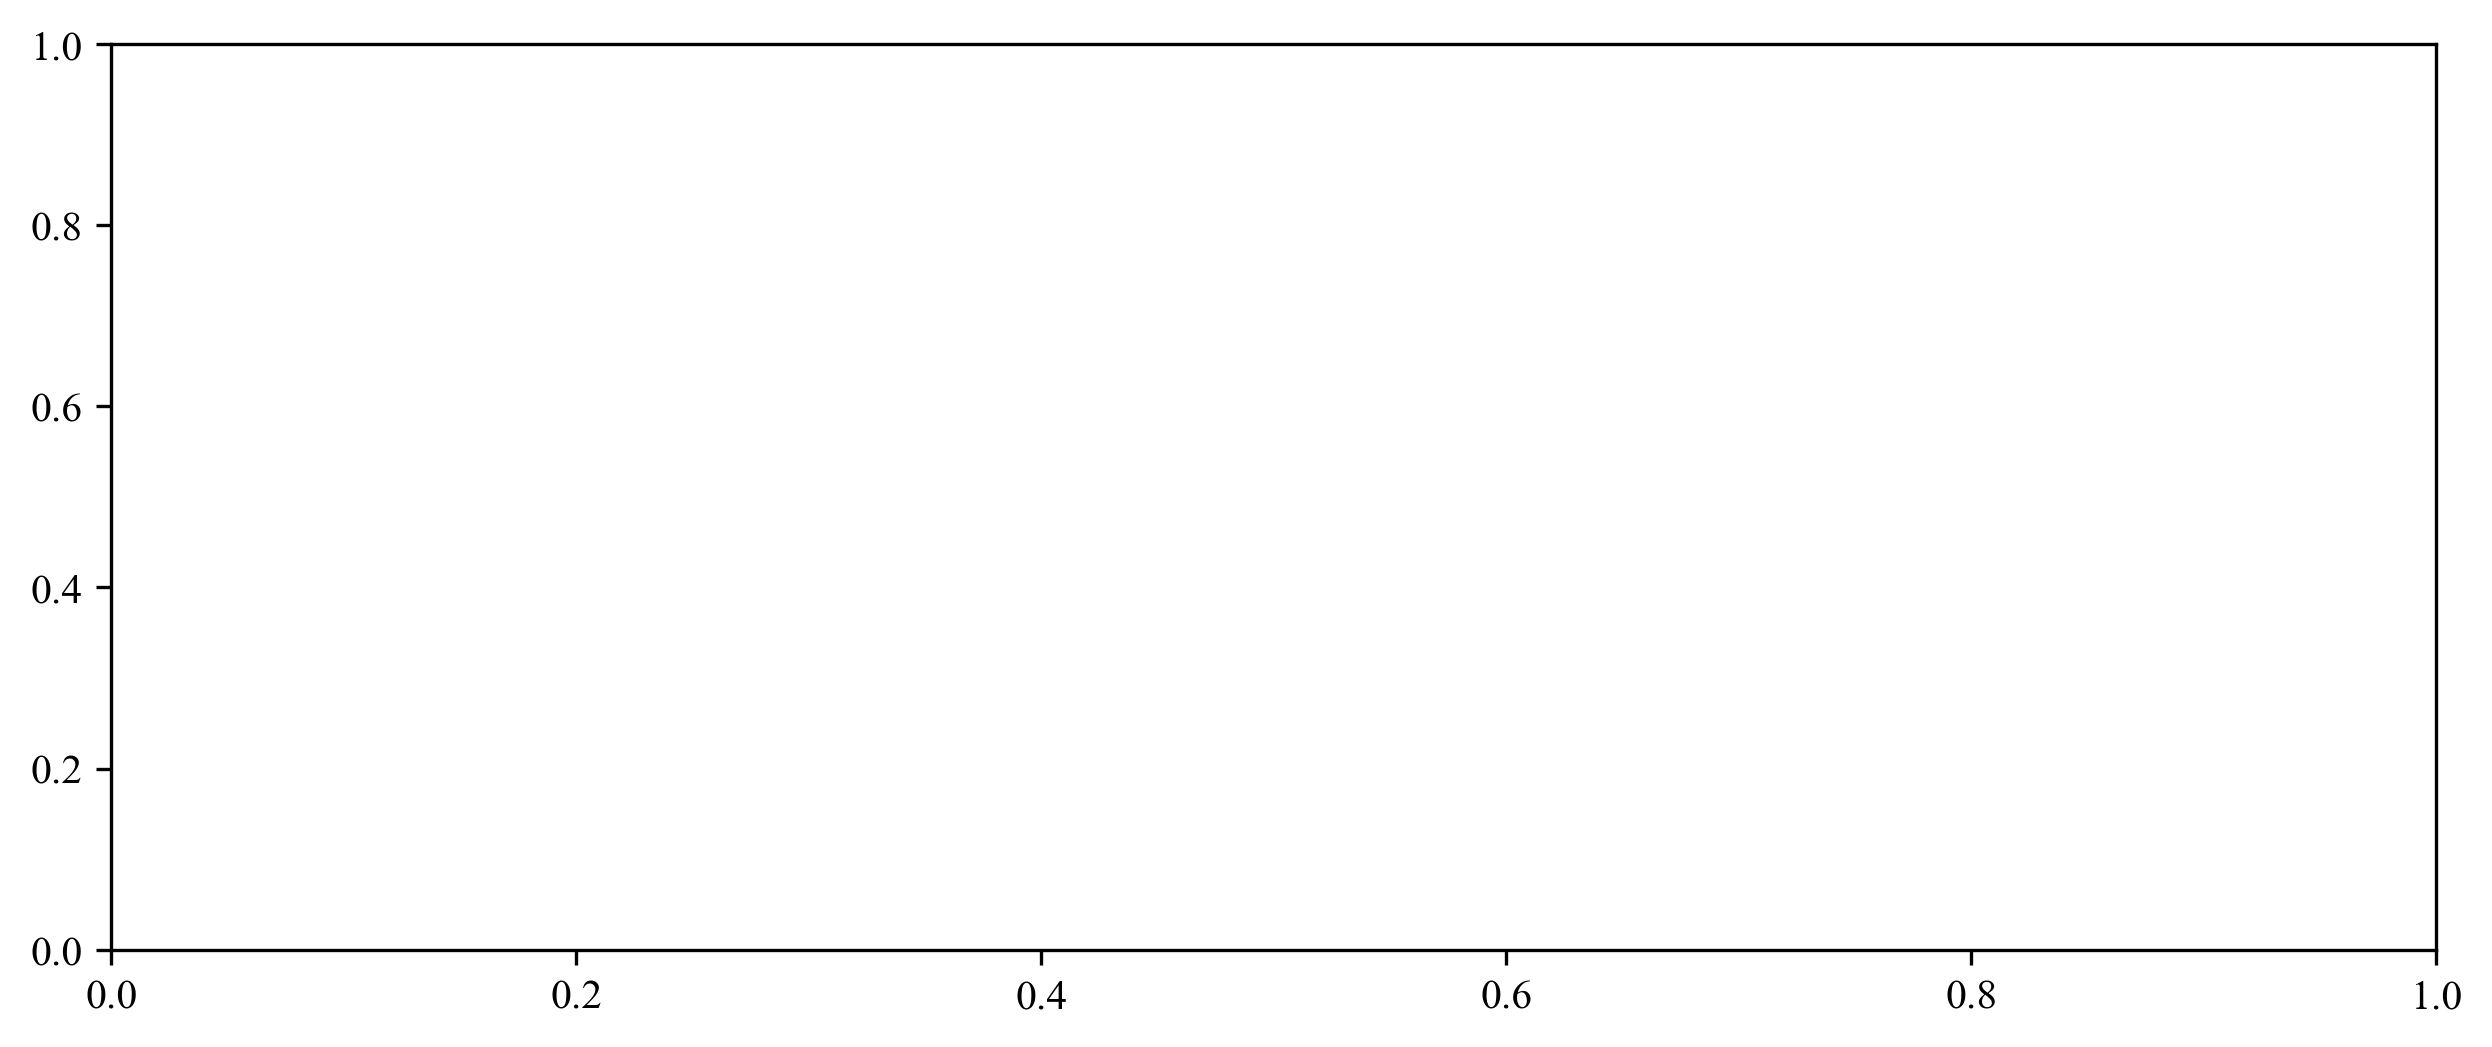

In [48]:
# %matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['inventor']):
    ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
ax.set_ylim([0,1.2])
ax.set_xlabel('Number of inventor candidates (K)', fontsize=15)
ax.set_ylabel('Matching rate', fontsize=15)
ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Inventor.jpg")

fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['department']):
    ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
ax2.set_ylim([0,1.2])
ax2.set_xlabel('Number of department candidates (K)', fontsize=15)
ax2.set_ylabel('Matching rate', fontsize=15)
ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax2.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Department.jpg")

In [121]:
# writer = pd.ExcelWriter("../results/revision_out.xlsx")
# for df in df_out.values():
#     df.to_excel(writer, sheet_name=df.index.name)
# writer.save()

Sensitivity analysis on vector size

In [503]:
candidates = {
    'n_epochs': [2500],
    'vector_size': [100, 200, 300],
    'window_size': [10],
    'n_neg_samples': [5]
}

In [ ]:
df_out = {}
for n_epochs in candidates['n_epochs']:
    for vector_size in candidates['vector_size']:
        for window_size in candidates['window_size']:
            for n_neg_samples in candidates['n_neg_samples']:
                stime = time.time()
                params['n_epochs'] = n_epochs
                params['vector_size'] = vector_size
                params['window_size'] = window_size
                params['n_neg_samples'] = n_neg_samples
                curr_params = "n"+str(params["n_epochs"])+"v"+str(params["vector_size"])+"w"+str(params["window_size"])+"neg"+str(params['n_neg_samples'])

                matching_rate = run(params=params)

                df_out[curr_params] = pd.DataFrame.from_dict(matching_rate).rename_axis(curr_params)
                etime = time.time()
                print(f"{np.round(etime-stime, 4)} sec elapsed\n")

[n_epochs: 2500, vector_size: 100, window_size: 10, n_neg_samples: 5]
model training done
1088.7537 sec elapsed

[n_epochs: 2500, vector_size: 200, window_size: 10, n_neg_samples: 5]


In [506]:
df_out

{'n2500v100w10neg5':                   i_n2500v100w10neg5  d_n2500v100w10neg5
 n2500v100w10neg5                                        
 0                             0.4040              0.5810
 1                             0.4688              0.6858
 2                             0.5162              0.7406
 3                             0.5411              0.8005
 4                             0.5686              0.8304
 5                             0.5810              0.8554
 6                             0.5910              0.8703
 7                             0.6035              0.8903
 8                             0.6135              0.8978
 9                             0.6160              0.9027,
 'n2500v200w10neg5':                   i_n2500v200w10neg5  d_n2500v200w10neg5
 n2500v200w10neg5                                        
 0                             0.3815              0.5686
 1                             0.4514              0.7057
 2                             

In [518]:
df_total_i_out.loc['i_n2500v300w10neg5']

n        2500
v         300
w          10
neg         5
0      0.3965
1      0.4589
2      0.5012
3      0.5362
4      0.5586
5      0.5736
6      0.5835
7      0.6035
8      0.6135
9       0.616
Name: i_n2500v300w10neg5, dtype: object

In [507]:
df_total_temp = pd.concat([df for df in df_out.values()], axis=1).T

In [509]:
df_total_temp_i = df_total_temp.loc[pd.Index([x for x in df_total_temp.index if "i" in x])]

In [511]:
df_total_temp_i.to_csv("../results/revision_out_v3(vector_size).csv")

## Previous results

In [493]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
# sbert_model = SentenceTransformer('allenai-specter')
# sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [58]:
from gensim.models import Word2Vec

In [67]:
wv_model = Word2Vec(sentences=sentences_to_train, vector_size=64, window=7, workers=4, min_count=1)

In [66]:
wv_model.train

<bound method Word2Vec.train of <gensim.models.word2vec.Word2Vec object at 0x7f976d7840d0>>

In [75]:
MODEL_DIR="../models"

model_type_to_load = input("Want to load Word2Vec model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): ")

if model_type_to_load in ['3', 'load_new']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "[w2v]Tech_licensing_new_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    wv_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_new_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_additional_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(wv_model.wv.key_to_index))

elif model_type_to_load in ['5', 'train_new']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    vector_size = input("Vector size: ")
    vector_size = int(vector_size)
    wv_model = Word2Vec(sentences=sentences_to_train, vector_size=vector_size, window=7, workers=4, min_count=1)
    wv_model.build_vocab(sentences_to_train)
    print("Vocab size",len(wv_model.wv.key_to_index))
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='[w2v]Tech_licensing_new_dim'+str(vector_size))
    epoch_logger = EpochLogger()
    wv_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False,
           callbacks=[epoch_saver, epoch_logger])

Want to load Word2Vec model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): 5
#epochs: 10000
Vector size: 64
Vocab size 12593
Loss after epoch 0: 0.0
Loss after epoch 50: 0.0
Loss after epoch 100: 0.0
Loss after epoch 150: 0.0
Loss after epoch 200: 0.0
Loss after epoch 250: 0.0
Loss after epoch 300: 0.0
Loss after epoch 350: 0.0
Loss after epoch 400: 0.0
Loss after epoch 450: 0.0
Loss after epoch 500: 0.0
Loss after epoch 550: 0.0
Loss after epoch 600: 0.0
Loss after epoch 650: 0.0
Loss after epoch 700: 0.0
Loss after epoch 750: 0.0
Loss after epoch 800: 0.0
Loss after epoch 850: 0.0
Loss after epoch 900: 0.0
Loss after epoch 950: 0.0
Loss after epoch 1000: 0.0
Loss after epoch 1050: 0.0
Loss after epoch 1100: 0.0
Loss after epoch 1150: 0.0
Loss after epoch 1200: 0.0
Loss after epoch 1250: 0.0
Loss after epoch 1300: 0.0
Loss after epoch 1350: 0.0
Loss after epoch 1400: 0.0
Loss after epoch 1450: 0.0
Loss after epoch 1500: 0.0
Loss after epoch 1550

In [76]:
wv_model

In [77]:
# vec_inv = calc_vec(ft_model, list_inv)
# vec_tech = calc_vec(ft_model, list_tech)

# vec_tech = calc_vec(ft_model, list_tech, method='avg', list_total=list_total)
# vec_inv = calc_vec(ft_model, list_inv, method='avg', list_total=list_total)

vec_tech = calc_vec(wv_model, list_tech, method='avg', list_total=list_total)
vec_inv = calc_vec(wv_model, list_inv, method='avg', list_total=list_total)

# vec_tech = calc_vec(ft_model, list_tech, method='sif_weight', list_total=list_total)
# vec_inv = calc_vec(ft_model, list_inv, method='sif_weight', list_total=list_total)

# vec_tech = calc_vec(sbert_model, list_tech, method='sbert', list_total=list_total)
# vec_inv = calc_vec(sbert_model, list_inv, method='sbert', list_total=list_total)

top_candidates = calc_rank(vec_tech, vec_inv, topk=10)

In [72]:
idx = 14
matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
for i in range(len(top_candidates[index_tech[idx]]['title'])):
    matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
matchmaking_example = matchmaking_example.T

display(matchmaking_example)

KeyError: 5000000808

In [73]:
top_candidates[index_tech[idx]]['title'].iloc[0]

'Automotive Object Recognition System and How it Works'

In [108]:
cnt_matched['inventor']

5000000737    1
5000000739    1
5000000740    0
5000000741    1
5000000751    1
             ..
5000002043    0
5000002044    1
5000002045    1
5000002046    1
5000002048    1
Length: 401, dtype: int64

In [114]:
top_candidates[id_target]['inventor']

inv_no
4000008564    박형민
2000029139    소재우
2000032049    정성원
2000030784    서용덕
26329         강석주
26623         김영록
2000025496    낭종호
4000007840    성원진
4000002470    유양모
31416          박석
Name: name, dtype: object

In [116]:
cnt_matched['inventor']

5000000737    1
5000000739    1
5000000740    0
5000000741    1
5000000751    1
             ..
5000002043    0
5000002044    1
5000002045    1
5000002046    1
5000002048    1
Length: 401, dtype: int64

In [117]:
outcomes.loc[id_target]

예외                                            NaN
학년도                                          2020
성과물구분                                           6
성과물구분명                                       기술이전
기준일                           2020-12-21 00:00:00
제목           우도 최대화를 이용한 빔포밍 방법 외 2건 특허 권리양도 기술이전
상위소속명                                         공학부
소속명                                        전자공학전공
교직원번호                                      101606
성명                                            박형민
관련연구과제                                        NaN
발송여부                                            예
성과물확인                                           예
교원업적                                          아니오
자료제출방법                                        NaN
연동여부(KRI)                                   False
검증여부                                          NaN
전송일시(KRI)                                     NaN
총저자수                                            0
Name: 5000002048, dtype: object

In [78]:
# Matching ratio
matching_rate = {'inventor': [], 'department': []}
for k in range(1,11):
    print("For top",k)
    top_candidates = calc_rank(vec_tech, vec_inv, topk=k)
    eval_matched = {}
    cnt_matched = {}
    cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    for id_target in tqdm(vec_tech.index):
        if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
            cnt_matched['inventor'].loc[id_target] += 1
        if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
            cnt_matched['department'].loc[id_target] += 1
    eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
    eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
    print("Hit ratio (inventor):", eval_matched['inventor'])
    print("Hit ratio (department):", eval_matched['department'])
    print("\n")
    matching_rate['inventor'].append(eval_matched['inventor'])
    matching_rate['department'].append(eval_matched['department'])

For top 1


100%|██████████| 565/565 [00:00<00:00, 3169.06it/s]


Hit ratio (inventor): 0.3274
Hit ratio (department): 0.5575


For top 2


100%|██████████| 565/565 [00:00<00:00, 3122.83it/s]


Hit ratio (inventor): 0.3894
Hit ratio (department): 0.6637


For top 3


100%|██████████| 565/565 [00:00<00:00, 3030.72it/s]


Hit ratio (inventor): 0.4549
Hit ratio (department): 0.7257


For top 4


100%|██████████| 565/565 [00:00<00:00, 3003.89it/s]


Hit ratio (inventor): 0.4991
Hit ratio (department): 0.7575


For top 5


100%|██████████| 565/565 [00:00<00:00, 2957.44it/s]


Hit ratio (inventor): 0.508
Hit ratio (department): 0.777


For top 6


100%|██████████| 565/565 [00:00<00:00, 2958.42it/s]


Hit ratio (inventor): 0.5257
Hit ratio (department): 0.7912


For top 7


100%|██████████| 565/565 [00:00<00:00, 2890.24it/s]


Hit ratio (inventor): 0.5398
Hit ratio (department): 0.8035


For top 8


100%|██████████| 565/565 [00:00<00:00, 2883.07it/s]


Hit ratio (inventor): 0.5558
Hit ratio (department): 0.8265


For top 9


100%|██████████| 565/565 [00:00<00:00, 2906.70it/s]


Hit ratio (inventor): 0.5628
Hit ratio (department): 0.8301


For top 10


100%|██████████| 565/565 [00:00<00:00, 2864.45it/s]

Hit ratio (inventor): 0.5841
Hit ratio (department): 0.8496




/tmp/ipykernel_17174/2674200302.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
/tmp/ipykernel_17174/2674200302.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)


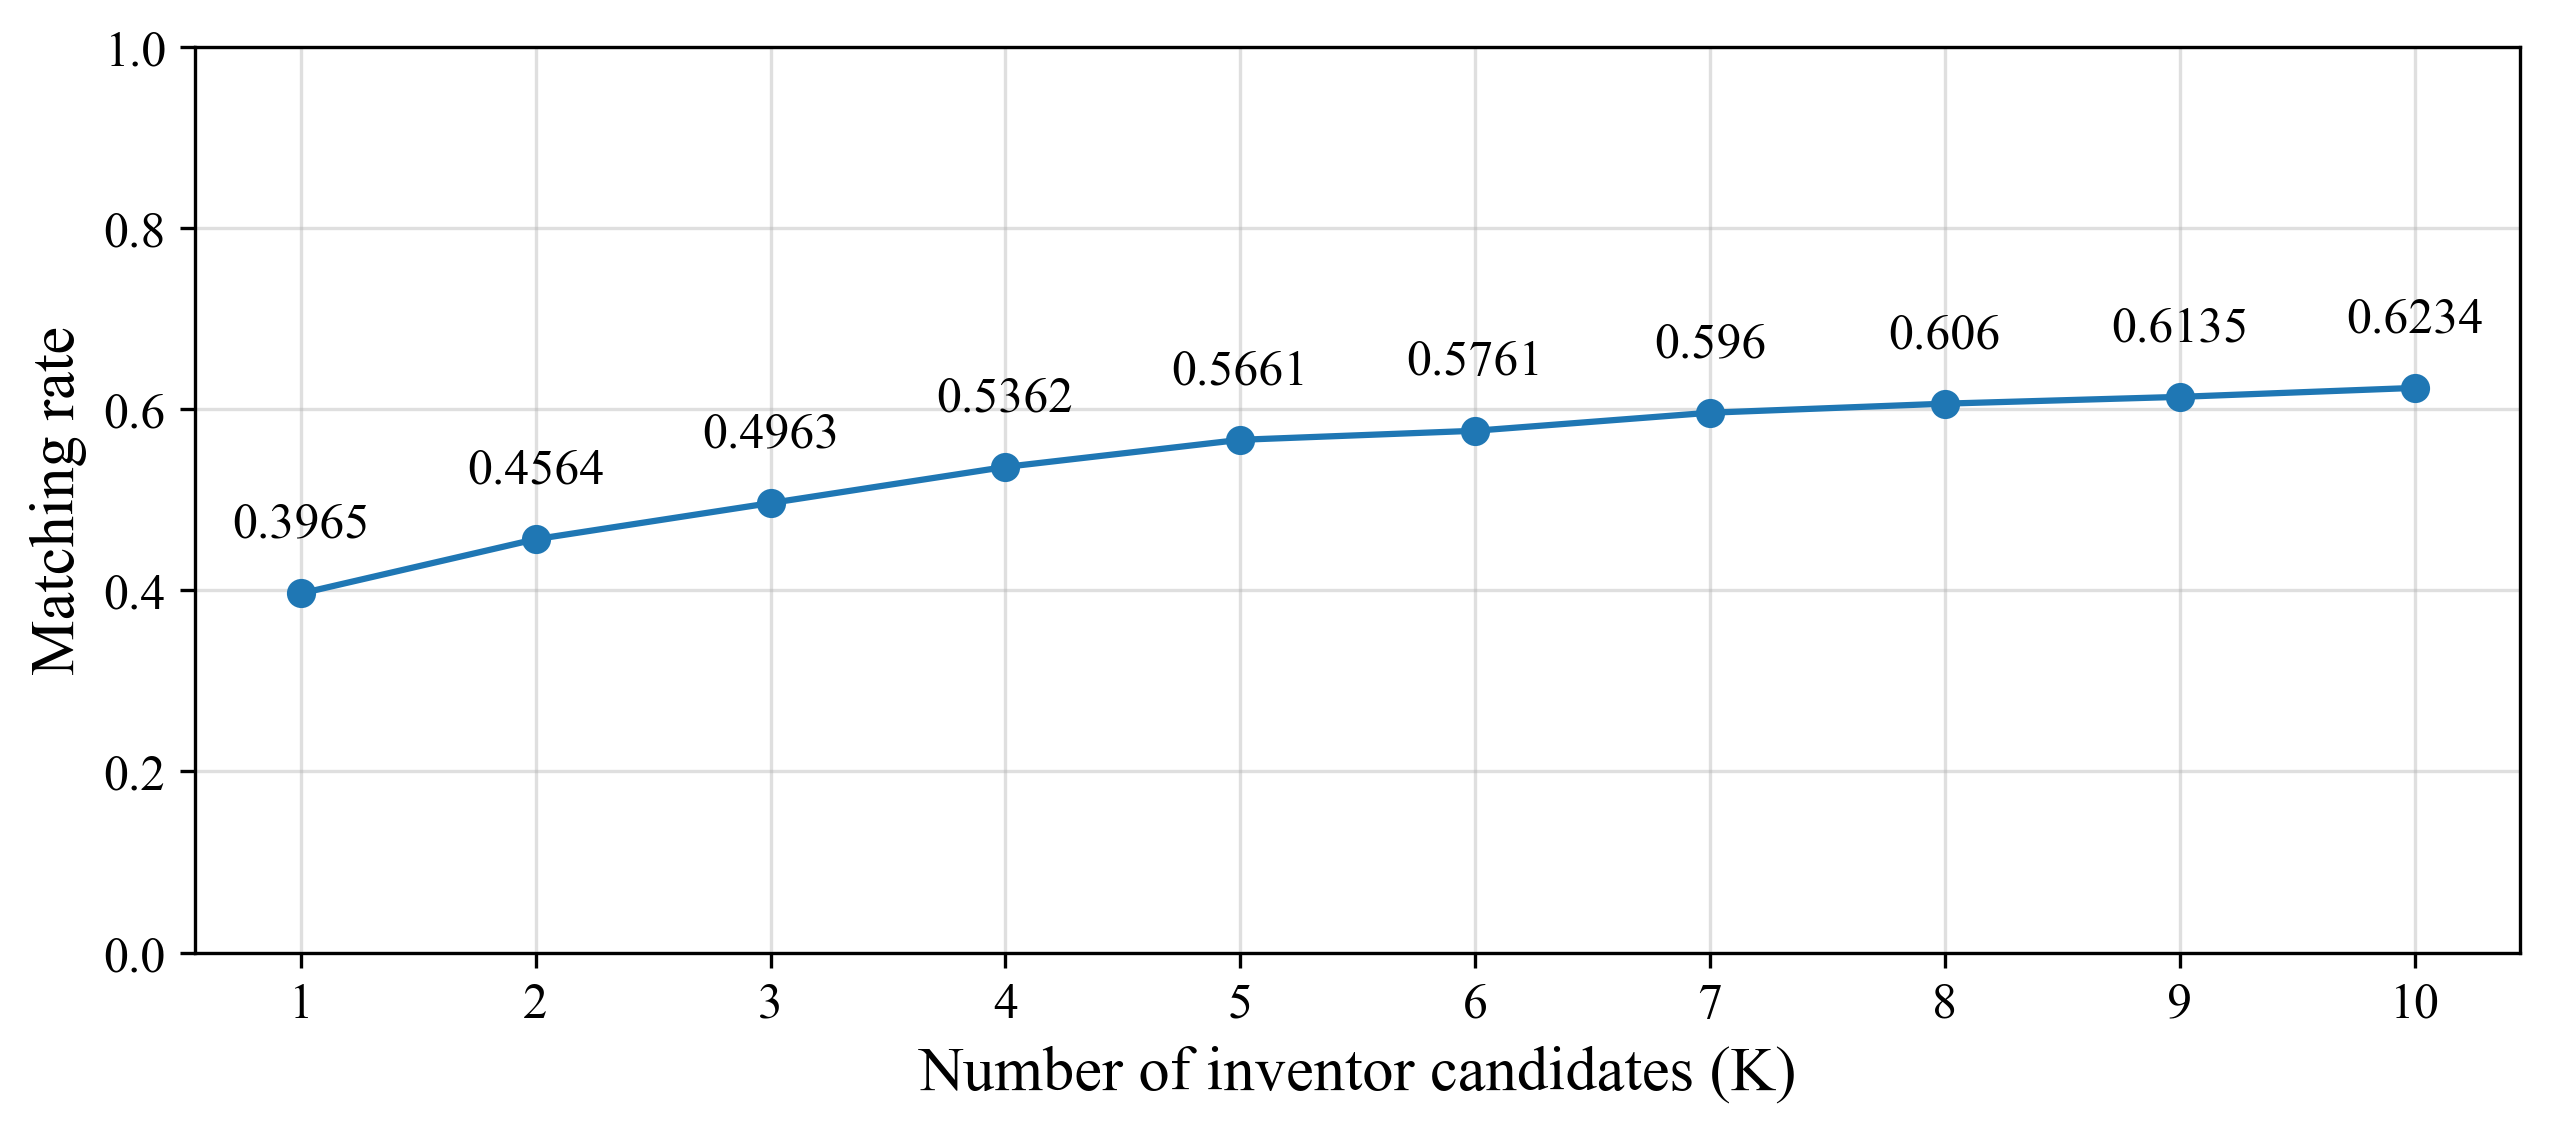

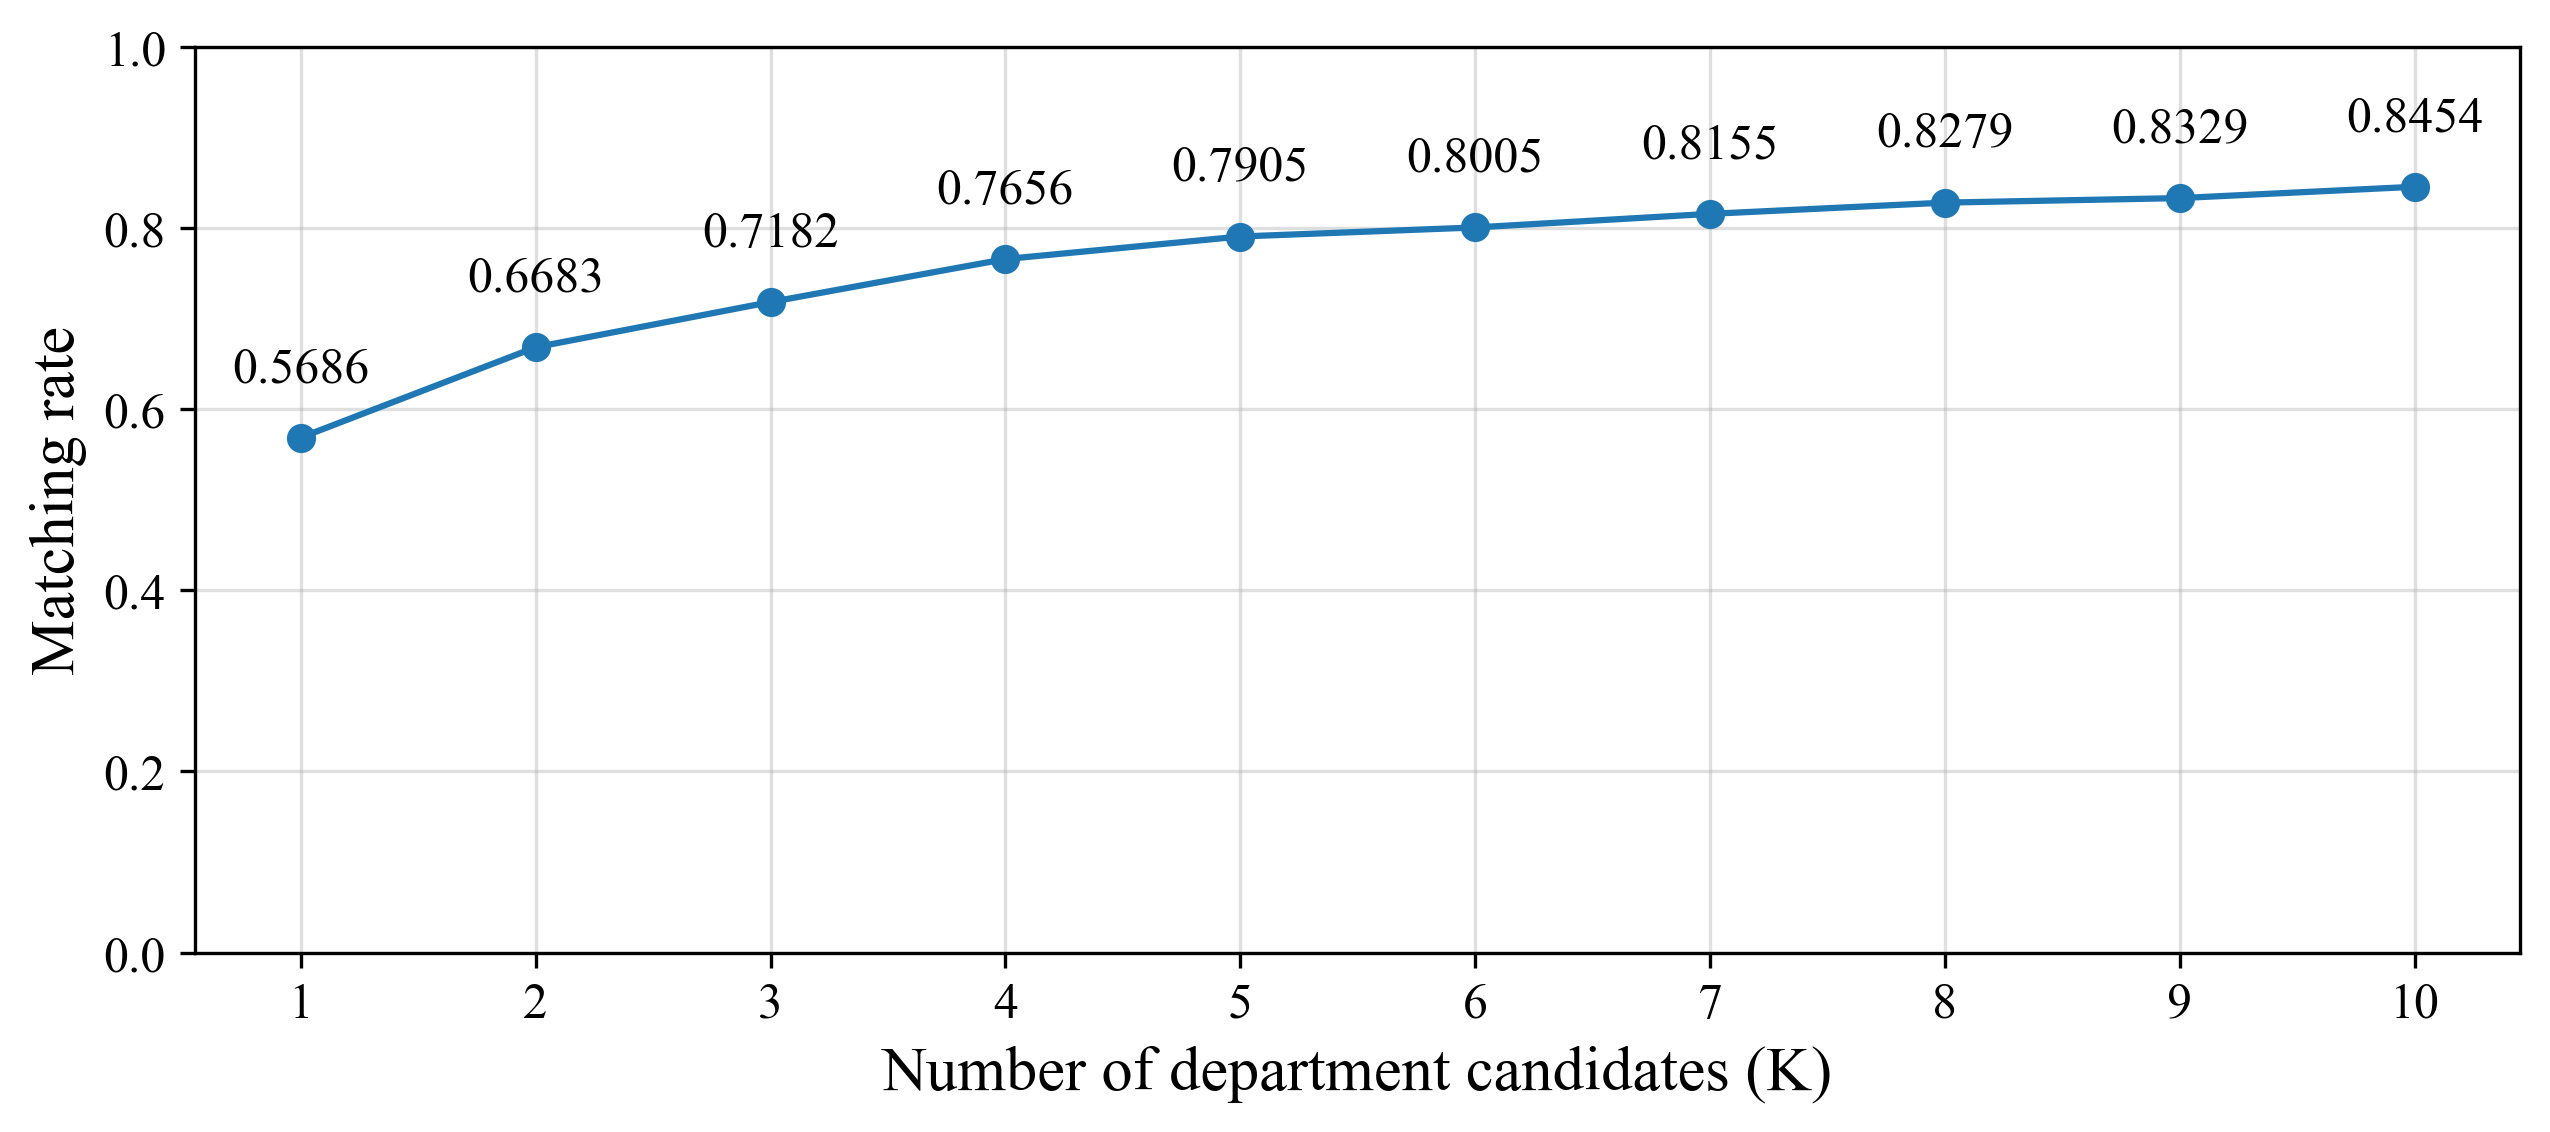

In [546]:
# %matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['inventor']):
    ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
ax.set_ylim([0,1])
ax.set_xlabel('Number of inventor candidates (K)', fontsize=15)
ax.set_ylabel('Matching rate', fontsize=15)
ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Inventor.jpg")

fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['department']):
    ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
ax2.set_ylim([0,1])
ax2.set_xlabel('Number of department candidates (K)', fontsize=15)
ax2.set_ylabel('Matching rate', fontsize=15)
ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax2.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Department.jpg")

In [ ]:
def get_result(method='avg'):
    print(f"For METHOD {method}")
    
    vec_tech = calc_vec(ft_model, list_tech, method=method, list_total=list_total)
    vec_inv = calc_vec(ft_model, list_inv, method=method, list_total=list_total)
    top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=10)

    idx = 16
    matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
    for i in range(len(top_candidates[index_tech[idx]]['title'])):
        matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
    matchmaking_example = matchmaking_example.T

    display(matchmaking_example)
    
    # Matching ratio
    matching_rate = {'inventor': [], 'department': []}
    for k in range(1,11):
        print("For top",k)
        top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=k)
        eval_matched = {}
        cnt_matched = {}
        cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        for id_target in tqdm(vec_tech.index):
            if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
                cnt_matched['inventor'].loc[id_target] += 1
            if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
                cnt_matched['department'].loc[id_target] += 1
        eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
        eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
        print("Hit ratio (inventor):", eval_matched['inventor'])
        print("Hit ratio (department):", eval_matched['department'])
        print("\n")
        matching_rate['inventor'].append(eval_matched['inventor'])
        matching_rate['department'].append(eval_matched['department'])
        
    # %matplotlib inline
    plt.rcParams['font.family'] = 'Times New Roman'

    fig, ax = plt.subplots(figsize=(10,4), dpi=300)
    ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['inventor']):
        ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
    ax.set_ylim([0,1])
    ax.set_xlabel('Number of inventor candidates', fontsize=15)
    ax.set_ylabel('Matching rate', fontsize=15)
    ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
    ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Inventor.jpg")

    fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
    ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['department']):
        ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
    ax2.set_ylim([0,1])
    ax2.set_xlabel('Number of departments', fontsize=15)
    ax2.set_ylabel('Matching rate', fontsize=15)
    ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
    ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax2.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Department.jpg")
    print("-"*50)

In [ ]:
methods = ['avg', 'sum', 'sif', 'sif_weight']
for method in methods:
    get_result(method=method)